In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import os

In [2]:
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
def read_csvs_in_folder(path_to_folder, verbose):
    # Get the files in the given directory, only files (not subdirectories)
    file_in_folder = [file for file in os.listdir(path_to_folder) if os.path.isfile(os.path.join(path_to_folder, file))]

    # For each file extract a dataframe and append it to a dataframe list. If required print it
    dataframe_list = []
    for idx, file in enumerate(file_in_folder):
        temp_df = pd.read_csv(path_to_folder+"/"+file)
        dataframe_list.append(temp_df)
        if verbose:
            print(f"Original input dataframe number:{idx}")
            print(temp_df)

    # Print the sum-up of the procedure
    print(f"\nProcessed {len(file_in_folder)} files {file_in_folder} from folder '{path_to_folder}' ")
    return dataframe_list

In [4]:
def plot_chart(dataframe, hz, first_frame, last_frame):
    # Clean the Stonex dataframe from samples with Stonex_status equal to 0 since they have a value of time tending to infinite
    # dataframe = dataframe.drop(dataframe[dataframe['Stonex_status'] == 0].index)
    # (Enable it only when working with new files that has this colum)

    # Get the initial offset between smartphone and Stonex on the yaw angle. It is acquired in the initial line of the dataframe
    # assuming that when this test starts the two device are not rotating. This offset is assumed constant throughout all the
    # process and is used later to adjust the Stonex yaw and bring it in line with the ARCore yaw, making them comparable.
    # This is necessary since wile the Stonex has always a yaw that is based on the Latitude global axis, the smartphone bases
    # its yaw on the ARCore -Z axis, which can be initialized differently between multiple AR sessions.
    initial_offset = dataframe['Delta_yaw_AR_Ston'][0]

    # Slice the dataframe to work only in the interested range
    dataframe = dataframe[first_frame:last_frame]

    # Plot a chart showing the three yaw values for arcore, Stonex and Stonex adjusted by the initial offset
    fig1, ax1 = plt.subplots()
    ax1.plot(dataframe['ARCore_yaw'], label="ARCore yaw")
    ax1.plot(dataframe['Stonex_yaw'], label="Stonex yaw")
    ax1.plot(dataframe['Stonex_yaw'] + initial_offset, label="Stonex adjusted yaw")
    ax1.set_title(f"ARCore vs Stonex vs Stonex adjusted yaw")
    ax1.set_ylabel("Yaw degrees [°]")
    ax1.set_xlabel(f"Samples [{hz}]")
    ax1.legend()

    # Plot a chart showing the delta between smartphone yaw and Stonex adjusted yaw
    fig2, ax2 = plt.subplots()
    ax2.plot(dataframe['Delta_yaw_AR_Ston'] - initial_offset)
    ax2.set_title(f"Yaw delta between ARCore and Stonex adjusted")
    ax2.set_ylabel("Yaw delta degrees [°]")
    ax2.set_xlabel(f"Samples [{hz}]")

    # Set the height and width of the plots, then show them
    fig1.set_figwidth(15)
    fig1.set_figheight(5)
    fig2.set_figwidth(15)
    fig2.set_figheight(5)
    plt.show()

In [5]:
def plot_yaw_charts_of_the_day(day_folder, hz="", first_last_frame_tuple_list_list=[[]], verbose=False):
    # Get the list of dataframe for the wanted day and frequency
    dataframe_list = read_csvs_in_folder(day_folder +"/yaw_comparison" + hz, verbose)

    # Ensure that first and last frame are defined for each dataframe in list, otherwise put them to (0,0),
    # meaning that the dataframe will be taken it all its range
    if len(first_last_frame_tuple_list_list) < len(dataframe_list):
        number_of_lists_with_empty_tuple_to_add = len(dataframe_list) - len(first_last_frame_tuple_list_list)
        for list_to_add in range(number_of_lists_with_empty_tuple_to_add):
            first_last_frame_tuple_list_list.append(list(tuple((0, 0))))

    # For each dataframe plot the chart of the wanted section
    for df_idx, df in enumerate(dataframe_list):
        for tuple_interval in first_last_frame_tuple_list_list[df_idx]:
            first_frame = tuple_interval[0] #TODO: Fix that if "first_last_frame_tuple_list_list" = [] it does not work
            last_frame = tuple_interval[1]
            if last_frame == 0:
                last_frame = len(df) - 1
            plot_chart(df, hz, first_frame, last_frame)

In [6]:
def plot_histogram(df, hz, initial_offset, n_bins, verbose_steps=False):
    frame_list = []
    # For each row in the given dataframe get its Stonex adjusted yaw and compare it with the previous [n_bins] values of ARCore yaw
    for row in range(len(df)):
        # Compute the Stonex adjusted yaw
        adjusted_stonex_yaw = df.iloc[row,3] + initial_offset  # Columns 3 is: "Stonex_yaw"

        # If we are in the firsts rows of the dataframe and we have not enough previous rows (n_bins-1) to carry out all
        # the comparison then skip the current comparison, since it would not lead to a fair results
        if verbose_steps:
            print(f"\nSliced df row: {row} ARCore yaw: {df.iloc[row,2]} vs Stonex adjusted yaw: {round(adjusted_stonex_yaw, 3)}")
        if row < n_bins-1:
            if verbose_steps:
                print(f"Insufficient number of previous samples ({row}) for this comparison ({n_bins-1} required), skipping it")
            continue

        # Otherwise, if we have enough previous rows to carry out all the comparisons, then start with a big yaw_offset and find the
        # row that is best aligned with the current row (i.e., that minimizes the yaw offset between ARCore and stonex adjusted)
        min_yaw_offset = 360
        best_frame = 0
        for packets_jumped_backwards in range(0, n_bins):
            yaw_offset = abs(df.iloc[row - packets_jumped_backwards,2] - adjusted_stonex_yaw)  # Columns 2 is: "ARCore_yaw"
            if yaw_offset < min_yaw_offset:
                min_yaw_offset = yaw_offset
                best_frame = packets_jumped_backwards
                if verbose_steps :
                    print(f"New min: [Difference:{round(yaw_offset, 3)}] between ARCore yaw (row{row - packets_jumped_backwards}): "
                      f"{df.iloc[row - packets_jumped_backwards,2]} and Adjusted yaw (row{row}): {round(adjusted_stonex_yaw, 3)}")
            else:
                if verbose_steps :
                    print(f"No  min: [Difference:{round(yaw_offset, 3)}] between ARCore yaw (row{row - packets_jumped_backwards}): "
                          f"{df.iloc[row - packets_jumped_backwards,2]} and Adjusted yaw (row{row}): {round(adjusted_stonex_yaw, 3)}")
        frame_list.append(best_frame)
        if verbose_steps:
            print(f"Packets back-jumped: {best_frame}")

    # Plot a histogram showing how the jumped packets are distributed, i.e. how many rows we need to go back in the dataframe align
    # in the best way the current row stonex adjusted yaw with the ARCore yaw
    fig, ax = plt.subplots()
    ax.hist(frame_list, bins=range(n_bins+1), align='left')
    ax.set_xticks(range(n_bins))
    ax.set_title("Distribution of packets back-jumped for optimal alignment")
    ax.set_ylabel("Number of occurrences")
    ax.set_xlabel(f"Packets jumped [{hz}]")

    # Set the height and width of the plots, then show them
    fig.set_figwidth(2*n_bins)
    fig.set_figheight(4)
    plt.show()

In [7]:
def plot_histograms_of_the_day(day_folder, hz="", first_last_frame_tuple_list=[], n_bins=(2, 3, 4), verbose_slice=True, verbose_steps=False, verbose_extraction=False):
    # Get the list of dataframe for the wanted day and frequency
    dataframe_list = read_csvs_in_folder(day_folder +"/yaw_comparison" + hz, verbose_extraction)

    # Ensure that first and last frame are defined for each dataframe in list, otherwise put them to (0,0),
    # meaning that the dataframe will be taken it all its range
    if len(first_last_frame_tuple_list) < len(dataframe_list):
        number_of_tuples_to_add = len(dataframe_list) - len(first_last_frame_tuple_list)
        for tuple_to_add in range(number_of_tuples_to_add):
            first_last_frame_tuple_list.append(tuple((0,0)))

    # For each dataframe plot the chart of the wanted section
    for idx, df in enumerate(dataframe_list):
        # Get the initial offset between smartphone and Stonex on the yaw angle.
        initial_offset = df['Delta_yaw_AR_Ston'][0]

        first_frame = first_last_frame_tuple_list[idx][0]
        last_frame = first_last_frame_tuple_list[idx][1]
        if last_frame == 0:
            last_frame = len(df) - 1

        # Slice the dataframe to work only in the interested range, then plot a histogram for all the specified number of bins
        df = df[first_frame:last_frame]
        if verbose_slice:
            print(f"Sliced dataframe number:{idx}")
            print(df)

        for n_bin in n_bins:
            plot_histogram(df, hz, initial_offset, n_bin, verbose_steps)

In [8]:
def merge_interval_tuples(input_interval_tuple_list, max_merge_frame_distance):
    # Merge together the interval tuples that are close
    temp_interval_list = []
    for tuple_idx, current_interval_tuple in enumerate(input_interval_tuple_list):
        # If this i not on the last tuple of the list then extract the next one needed for the merge
        if tuple_idx != len(input_interval_tuple_list)-1:
            next_interval_tuple =  input_interval_tuple_list[tuple_idx+1]

            # If the current tuple end is close enough to the next tuple start begin the merge
            if current_interval_tuple[1] >= next_interval_tuple[0] - max_merge_frame_distance:
                # Merge the tuples and put them into a new list
                merged_tuple = (current_interval_tuple[0],next_interval_tuple[1])
                temp_interval_list.append(merged_tuple)
                # Extend the list with all the other tuples not merged yet and start a new recursion
                temp_interval_list.extend(input_interval_tuple_list[tuple_idx+2:])
                return merge_interval_tuples(temp_interval_list, max_merge_frame_distance)

            # If the current tuple end is NOT close enough to the next tuple start, then avoid the merge
            else:
                # Put the current tuple into a list, and give the input_list (without the current tuple) to
                # the recursive call to see if other merges are possible in the other part of the list
                temp_interval_list.append(current_interval_tuple)
                following_merges = merge_interval_tuples(input_interval_tuple_list[1:], max_merge_frame_distance)
                # If the returned list with merged tuples has at least one element then use it to extend the list
                # composed of the tuple left out from the recursion. Finally return it
                if len(following_merges) > 0:
                    temp_interval_list.extend(following_merges)
                return temp_interval_list

        # If this is the last tuple of the input list then return the input list since no more merge can be performed
        return input_interval_tuple_list

    # If an empty list of tuple is given in input, end instantly the for cycle and return another empty list.
    # This will be used as argument in the list extension performed going back into the recursions
    return []

In [9]:
def find_steep_ranges(df, hz, percentage_of_movement, max_merge_frame_distance):
    # We use only the arcore value since it is the one with the smoothest curve
    previous_arcore_yaw_value = -1000
    moved_frame_list = []
    fixed_frame_list = []
    for row in range(len(df)):
        current_arcore_yaw_value = df.iloc[row,2]
        if previous_arcore_yaw_value == -1000:
            previous_arcore_yaw_value = current_arcore_yaw_value
            continue

        if ((abs(previous_arcore_yaw_value) - abs(current_arcore_yaw_value)) > (abs(previous_arcore_yaw_value)/100)*percentage_of_movement or \
                (abs(current_arcore_yaw_value) - abs(previous_arcore_yaw_value)) > (abs(previous_arcore_yaw_value)/100)*percentage_of_movement) and \
                (abs(previous_arcore_yaw_value) - abs(current_arcore_yaw_value)) < (abs(previous_arcore_yaw_value)/100)*15:
            # print(f"Row: {row}: Moved", current_arcore_yaw_value)
            moved_frame_list.append(row)
        else:
            # print(f"Row: {row}: Fixed", current_arcore_yaw_value)
            fixed_frame_list.append(row)

        previous_arcore_yaw_value = current_arcore_yaw_value
    print(f"Moved frame list(len:{len(moved_frame_list)})")
    print(f"Fixed frame list(len:{len(fixed_frame_list)})")

    # Build interval tuples using the previously computed data
    moved_frame_interval_tuple_list = []
    initial_frame_of_interval = -1
    previous_frame = -1
    final_frame_of_interval = -1
    for current_frame in moved_frame_list:
        if initial_frame_of_interval == -1:
            initial_frame_of_interval = current_frame
            previous_frame = current_frame
            continue
        if current_frame == previous_frame + 1:
            final_frame_of_interval = current_frame
            previous_frame = current_frame
            if current_frame != moved_frame_list[len(moved_frame_list)-1]:
                continue

        current_interval_tuple = (initial_frame_of_interval, final_frame_of_interval)
        moved_frame_interval_tuple_list.append(current_interval_tuple)
        initial_frame_of_interval = current_frame
        previous_frame = current_frame
    print(f"Moved frame interval list(len:{len(moved_frame_interval_tuple_list)}): {moved_frame_interval_tuple_list}")

    # Merge together the interval tuples that are close
    moved_frame_interval_tuple_list = merge_interval_tuples(moved_frame_interval_tuple_list, max_merge_frame_distance)
    print(f"Moved frame merged interval list(len:{len(moved_frame_interval_tuple_list)}): {moved_frame_interval_tuple_list}")

    # Get the initial offset between smartphone and Stonex on the yaw angle.
    initial_offset = df['Delta_yaw_AR_Ston'][0]

    # Plot a chart showing the three yaw values for arcore, Stonex and Stonex adjusted by the initial offset
    fig1, ax1 = plt.subplots()
    ax1.plot(df['ARCore_yaw'], label="ARCore yaw")
    ax1.plot(df['Stonex_yaw'] + initial_offset, label="Stonex adjusted yaw")
    ax1.set_title(f"ARCore vs Stonex vs Stonex adjusted yaw")
    ax1.set_ylabel("Yaw degrees [°]")
    ax1.set_xlabel(f"Samples [{hz}]")
    ax1.legend()

    # If moved and fixed frame list are not empty the color the chart background using them
    if len(moved_frame_list) > 0 and len(fixed_frame_list) > 0:
        for frame in moved_frame_list:
            ax1.axvspan(frame, frame+1, facecolor='b', alpha=0.5)

    # Set the height and width of the plot, then show it
    fig1.set_figwidth(15)
    fig1.set_figheight(5)
    plt.show()

    return moved_frame_interval_tuple_list

In [10]:
def find_steep_ranges_of_the_day(day_folder, hz="", percentage_of_movement=2, max_merge_frame_distance=10, verbose_extraction=False):
    # Get the list of dataframe for the wanted day and frequency
    dataframe_list = read_csvs_in_folder(day_folder +"/yaw_comparison" + hz, verbose_extraction)
    dataframe_lists_of_intervals = []

    # For each dataframe plot the chart of the wanted section
    for idx, df in enumerate(dataframe_list):
        moved_frame_interval_list = find_steep_ranges(df, hz, percentage_of_movement, max_merge_frame_distance)
        dataframe_lists_of_intervals.append(moved_frame_interval_list)

    return dataframe_lists_of_intervals

# 1.0 AUTOMATIC ANALYSIS

## 1.1 Analysis on date 2023_5_2 (1 file)
### Mixture of movements
#### Measurements specific for the yaw with a continuous movement have been carried on in the day of 2023_5_2 at 5Hz

Original input dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston
0    2023-05-02 16:50:07.186  2023-05-02 16:50:07.6      -41.68 -111.863098          70.183098
1    2023-05-02 16:50:07.186  2023-05-02 16:50:07.6      -41.68 -111.902199          70.222199
2    2023-05-02 16:50:07.351  2023-05-02 16:50:07.8      -41.74 -111.902199          70.162197
3    2023-05-02 16:50:07.448  2023-05-02 16:50:07.8      -41.65 -111.906616          70.256614
4    2023-05-02 16:50:07.579  2023-05-02 16:50:08.0      -41.67 -111.906616          70.236618
..                       ...                    ...         ...         ...                ...
849  2023-05-02 16:51:35.595  2023-05-02 16:51:36.0       44.02  -26.716978          70.736978
850  2023-05-02 16:51:35.737  2023-05-02 16:51:36.2       45.89  -26.716978          72.606977
851  2023-05-02 16:51:35.837  2023-05-02 16:51:36.2       47.75  -24.455702          72.205702
852  2023-05-02 

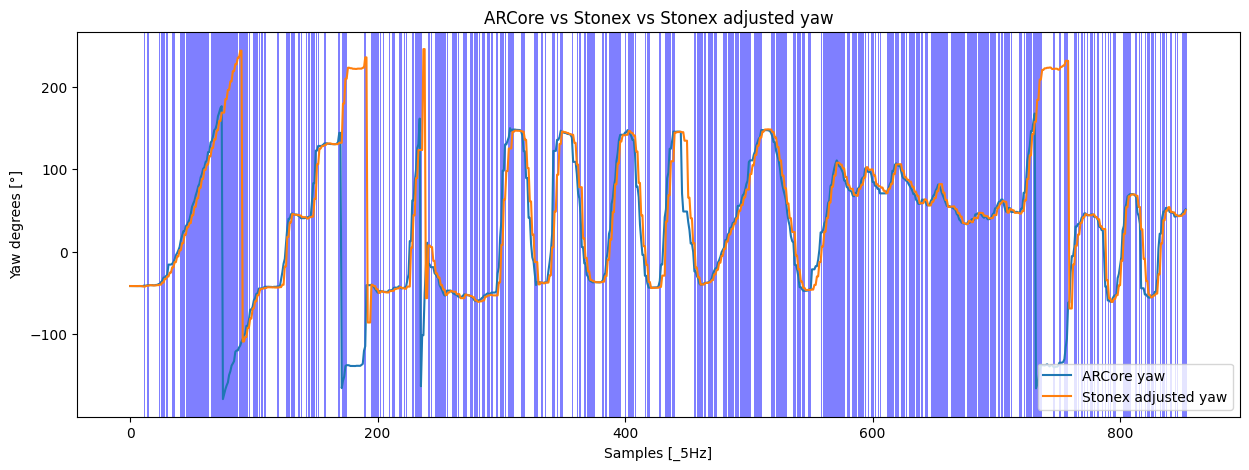

[[(11, -1),
  (14, -1),
  (23, -1),
  (25, 27),
  (29, 30),
  (34, 35),
  (40, 43),
  (45, 63),
  (65, 86),
  (88, 94),
  (96, 94),
  (99, 102),
  (104, 102),
  (106, 102),
  (108, 109),
  (119, 109),
  (126, 128),
  (130, 132),
  (136, 132),
  (138, 132),
  (142, 132),
  (144, 132),
  (146, 148),
  (150, 148),
  (152, 148),
  (157, 148),
  (168, 169),
  (171, 174),
  (189, 190),
  (195, 200),
  (202, 200),
  (204, 200),
  (209, 200),
  (212, 213),
  (217, 219),
  (221, 219),
  (223, 219),
  (228, 219),
  (230, 235),
  (241, 235),
  (243, 235),
  (246, 254),
  (256, 254),
  (260, 263),
  (265, 263),
  (269, 271),
  (275, 276),
  (278, 280),
  (282, 280),
  (284, 286),
  (288, 290),
  (292, 290),
  (296, 290),
  (299, 301),
  (303, 301),
  (305, 309),
  (316, 318),
  (326, 329),
  (332, 333),
  (335, 333),
  (341, 342),
  (345, 342),
  (347, 349),
  (357, 349),
  (361, 349),
  (363, 349),
  (367, 349),
  (369, 375),
  (381, 382),
  (384, 382),
  (387, 396),
  (400, 396),
  (402, 406),
 

In [19]:
find_steep_ranges_of_the_day("files/2023_5_2", "_5Hz", 1, 10, True)

Original input dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston
0    2023-05-02 16:50:07.186  2023-05-02 16:50:07.6      -41.68 -111.863098          70.183098
1    2023-05-02 16:50:07.186  2023-05-02 16:50:07.6      -41.68 -111.902199          70.222199
2    2023-05-02 16:50:07.351  2023-05-02 16:50:07.8      -41.74 -111.902199          70.162197
3    2023-05-02 16:50:07.448  2023-05-02 16:50:07.8      -41.65 -111.906616          70.256614
4    2023-05-02 16:50:07.579  2023-05-02 16:50:08.0      -41.67 -111.906616          70.236618
..                       ...                    ...         ...         ...                ...
849  2023-05-02 16:51:35.595  2023-05-02 16:51:36.0       44.02  -26.716978          70.736978
850  2023-05-02 16:51:35.737  2023-05-02 16:51:36.2       45.89  -26.716978          72.606977
851  2023-05-02 16:51:35.837  2023-05-02 16:51:36.2       47.75  -24.455702          72.205702
852  2023-05-02 

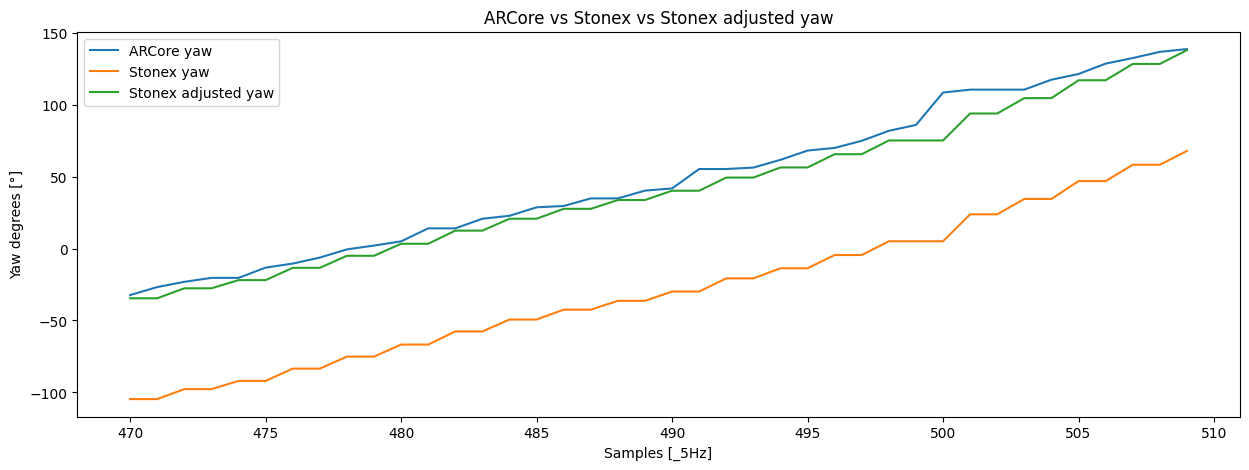

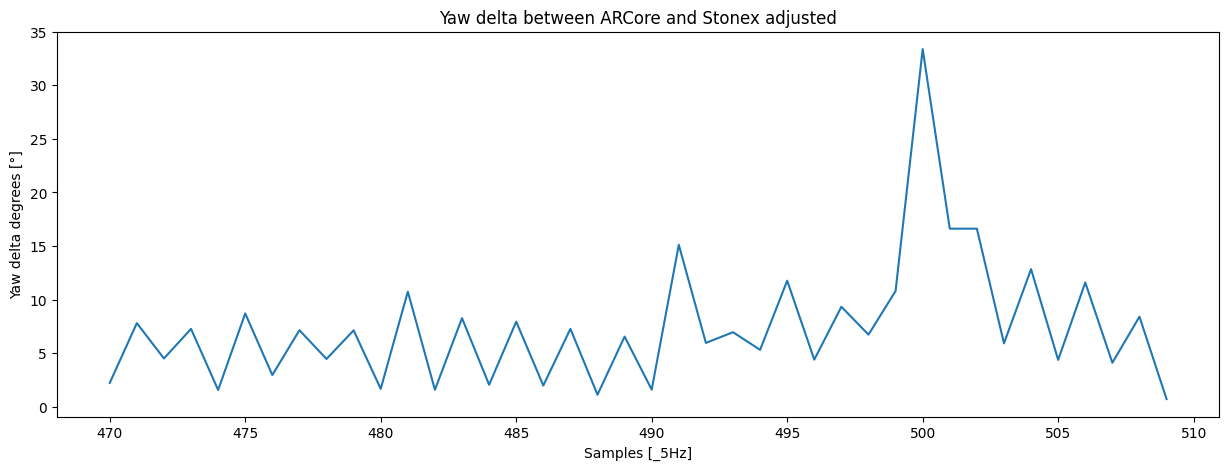

In [75]:
plot_yaw_charts_of_the_day("files/2023_5_2", "_5Hz", [(470, 510)], True) #TODO: Fix and use the automatic range here


Processed 1 files ['yaw_comparison_16-50-7.csv'] from folder 'files/2023_5_2/yaw_comparison_5Hz' 
Sliced dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston
470  2023-05-02 16:50:56.402  2023-05-02 16:50:56.8      -32.34 -104.741386          72.401386
471  2023-05-02 16:50:56.564  2023-05-02 16:50:57.0      -26.76 -104.741386          77.981386
472  2023-05-02 16:50:56.702  2023-05-02 16:50:57.0      -23.12  -97.805176          74.685175
473  2023-05-02 16:50:56.772  2023-05-02 16:50:57.2      -20.36  -97.805176          77.445175
474  2023-05-02 16:50:56.772  2023-05-02 16:50:57.2      -20.36  -92.105026          71.745025
..                       ...                    ...         ...         ...                ...
505  2023-05-02 16:51:00.017  2023-05-02 16:51:00.4      121.58   47.027954          74.552048
506  2023-05-02 16:51:00.144  2023-05-02 16:51:00.6      128.80   47.027954          81.772049
507  2023-05-02 16:5

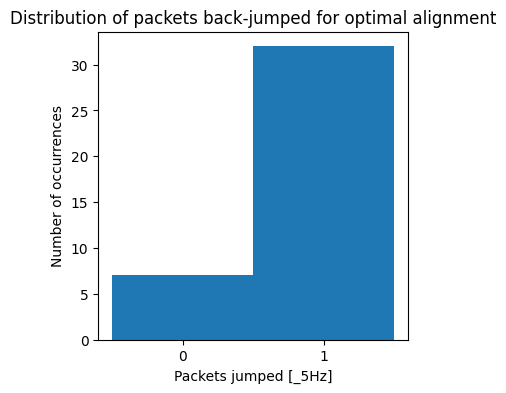

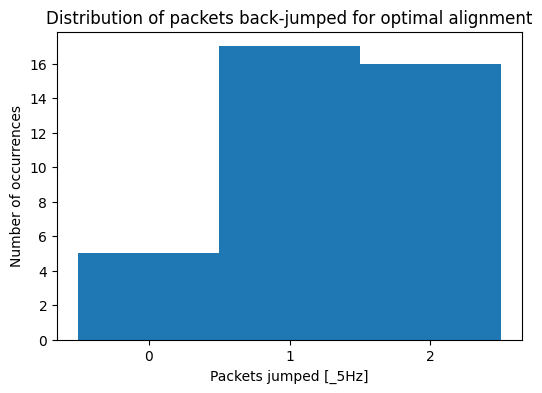

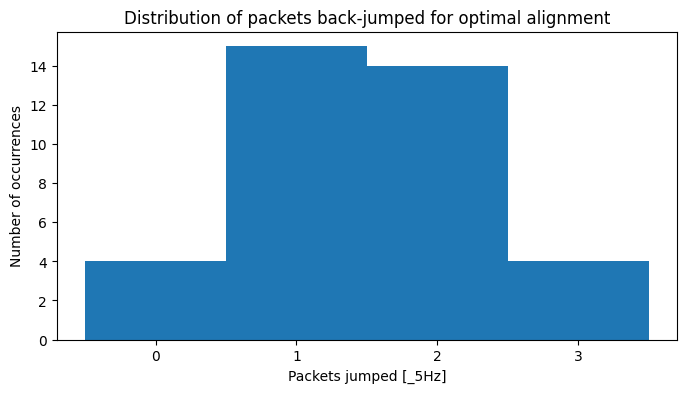

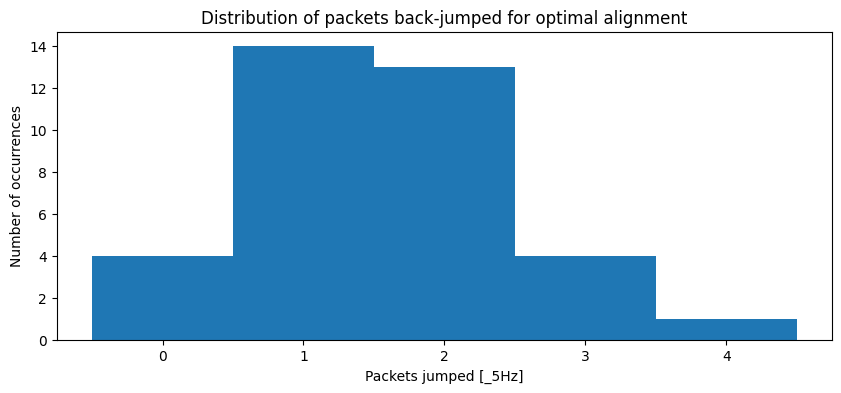

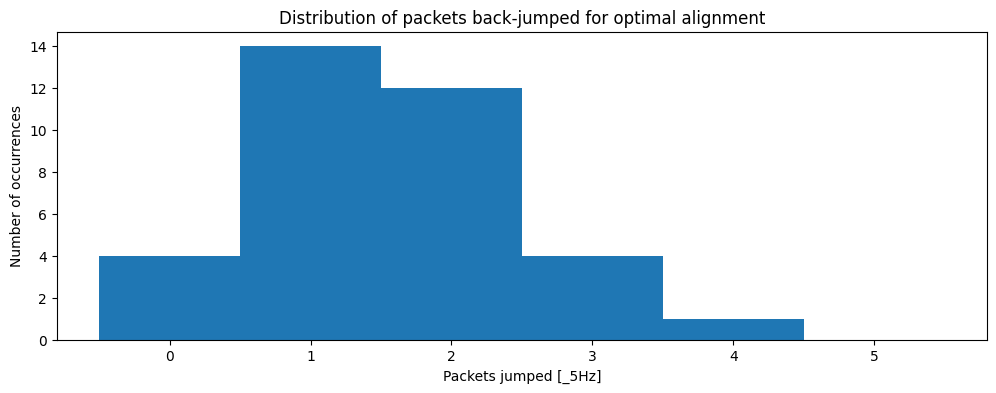

In [21]:
plot_histograms_of_the_day("files/2023_5_2", "_5Hz", [(470, 510)], [2,3,4,5,6], True, False, False)  #TODO: Fix and use the automatic range here

## 1.2 Analysis on date 2023_5_3, (2 files).
### File 1: continuous rotation for 360 degrees, File 2: 90degrees turn, stop, repeat until closing the cycle (3 cycles done)
#### Measurements specific for the yaw with an intermittent movement have been carried on in the day of 2023_5_3 both at 5Hz and 25Hz

### 1.2.1 5 Hz

Original input dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston  Stonex_status
0    2023-05-03 15:09:15.546  2023-05-03 15:09:15.8      -44.74    7.734663         -52.474665              2
1    2023-05-03 15:09:15.779  2023-05-03 15:09:16.0      -46.17    7.734663         -53.904661              2
2    2023-05-03 15:09:15.779  2023-05-03 15:09:16.0      -46.17    7.767914         -53.937912              2
3    2023-05-03 15:09:15.877  2023-05-03 15:09:16.2      -46.45    7.767914         -54.217915              2
4    2023-05-03 15:09:15.909  2023-05-03 15:09:16.2      -46.33    6.229918         -52.559920              2
..                       ...                    ...         ...         ...                ...            ...
139  2023-05-03 15:09:30.012  2023-05-03 15:09:30.2       11.85   53.979710         -42.129710              2
140  2023-05-03 15:09:30.112  2023-05-03 15:09:30.4       15.78   53.979710         -3

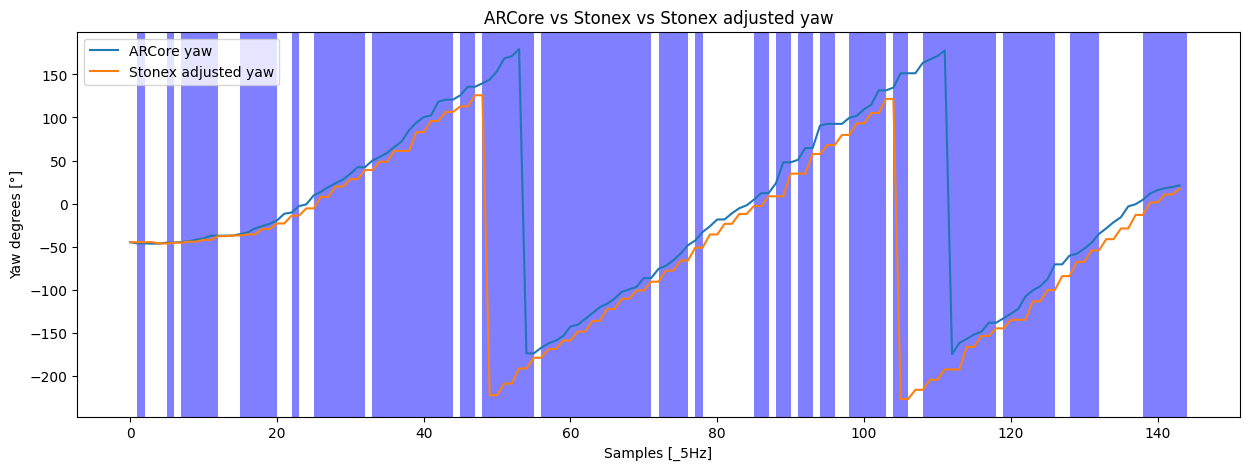

Moved frame list(len:130)
Fixed frame list(len:87)
Moved frame interval list(len:48): [(1, -1), (5, 7), (9, 10), (14, 10), (16, 17), (20, 22), (24, 25), (27, 33), (35, 33), (39, 33), (41, 42), (44, 47), (49, 47), (51, 47), (54, 55), (58, 59), (65, 66), (68, 69), (71, 69), (75, 79), (81, 83), (85, 83), (89, 83), (91, 101), (109, 101), (111, 101), (119, 122), (124, 122), (126, 127), (131, 127), (133, 134), (136, 138), (140, 138), (142, 138), (144, 148), (150, 154), (157, 158), (160, 163), (165, 163), (171, 163), (173, 163), (175, 179), (183, 185), (187, 185), (189, 194), (198, 203), (205, 207), (209, 217)]
Moved frame merged interval list(len:3): [(1, 101), (119, 163), (175, 217)]


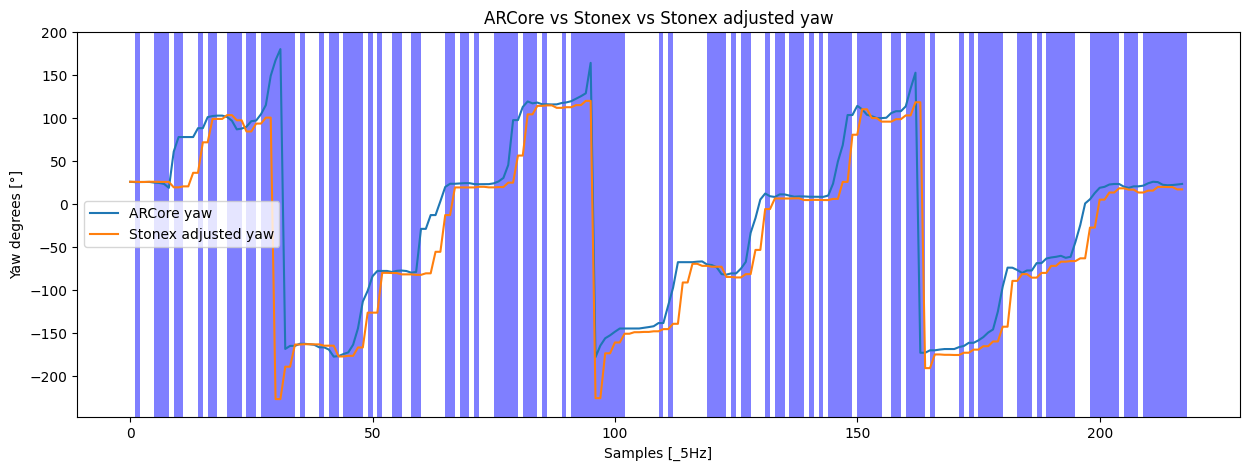

In [25]:
interesting_intervals_5hz = find_steep_ranges_of_the_day("files/2023_5_3", "_5Hz", 1, 10, True)

Original input dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston  Stonex_status
0    2023-05-03 15:09:15.546  2023-05-03 15:09:15.8      -44.74    7.734663         -52.474665              2
1    2023-05-03 15:09:15.779  2023-05-03 15:09:16.0      -46.17    7.734663         -53.904661              2
2    2023-05-03 15:09:15.779  2023-05-03 15:09:16.0      -46.17    7.767914         -53.937912              2
3    2023-05-03 15:09:15.877  2023-05-03 15:09:16.2      -46.45    7.767914         -54.217915              2
4    2023-05-03 15:09:15.909  2023-05-03 15:09:16.2      -46.33    6.229918         -52.559920              2
..                       ...                    ...         ...         ...                ...            ...
139  2023-05-03 15:09:30.012  2023-05-03 15:09:30.2       11.85   53.979710         -42.129710              2
140  2023-05-03 15:09:30.112  2023-05-03 15:09:30.4       15.78   53.979710         -3

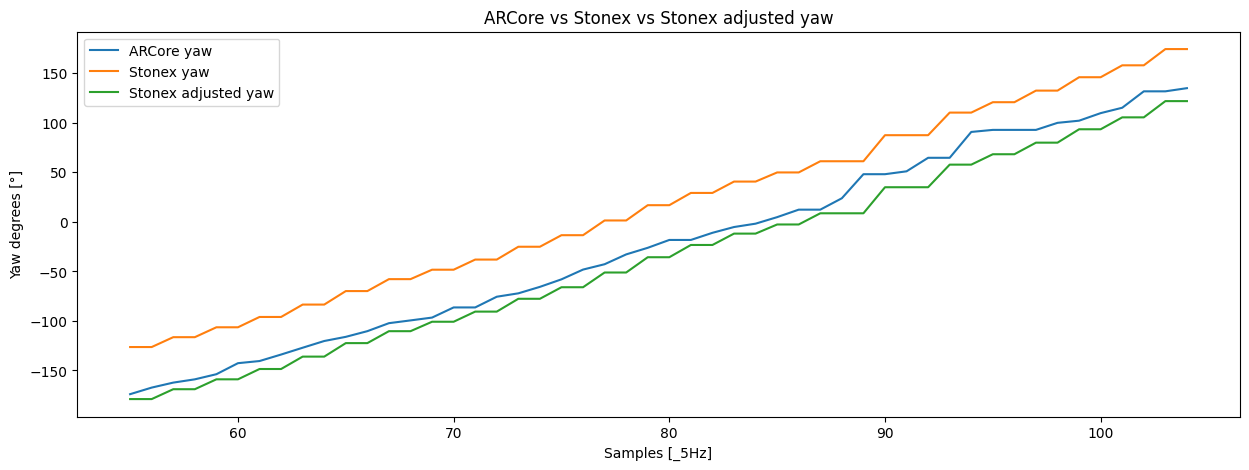

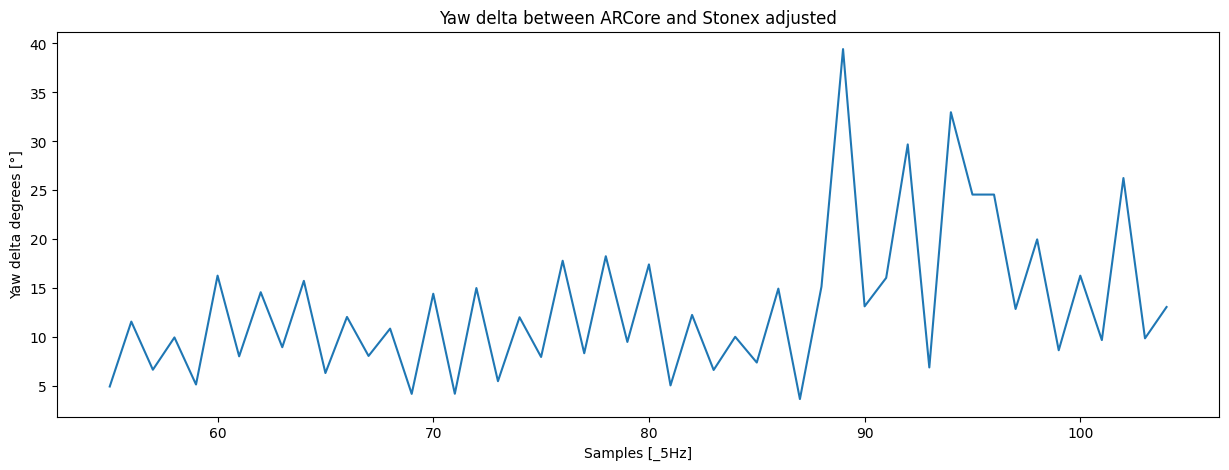

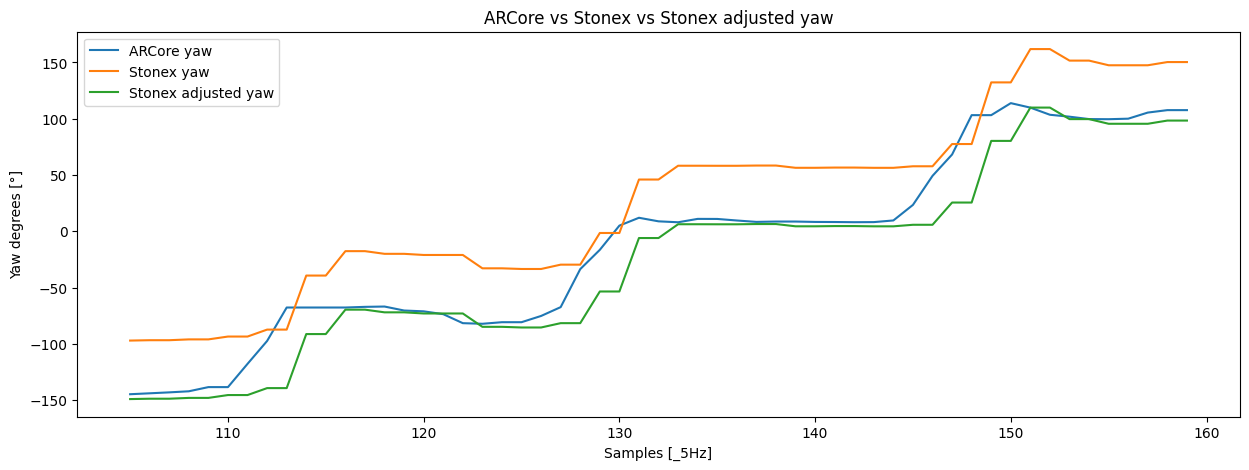

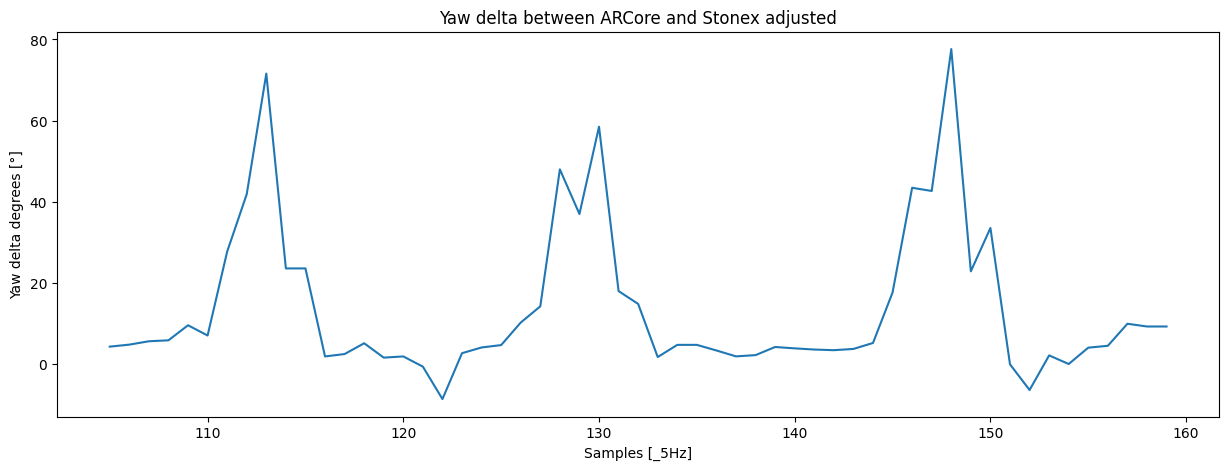

In [28]:
plot_yaw_charts_of_the_day("files/2023_5_3", "_5Hz", [[(55, 105)], [(105, 160)]], True) #TODO: Fix and use the automatic range here


Processed 2 files ['yaw_comparison_5Hz_15-9-15.csv', 'yaw_comparison_5Hz_15-9-35.csv'] from folder 'files/2023_5_3/yaw_comparison_5Hz' 
Sliced dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston  Stonex_status
55   2023-05-03 15:09:21.123  2023-05-03 15:09:21.4     -173.88 -126.356323         -47.523682              2
56   2023-05-03 15:09:21.255  2023-05-03 15:09:21.6     -167.25 -126.356323         -40.893677              2
57   2023-05-03 15:09:21.354  2023-05-03 15:09:21.6     -162.22 -116.409653         -45.810348              2
58   2023-05-03 15:09:21.421  2023-05-03 15:09:21.8     -158.92 -116.409653         -42.510345              2
59   2023-05-03 15:09:21.521  2023-05-03 15:09:21.8     -153.75 -106.431908         -47.318092              2
..                       ...                    ...         ...         ...                ...            ...
100  2023-05-03 15:09:25.867  2023-05-03 15:09:26.2      109.51  14

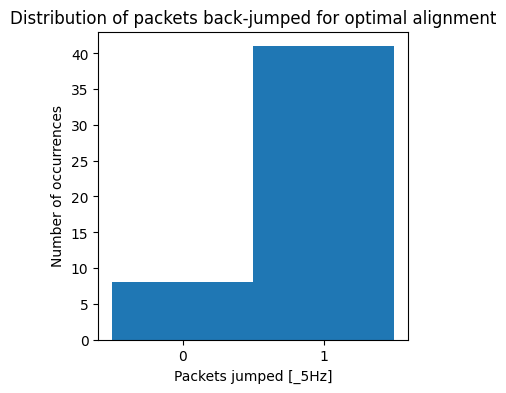

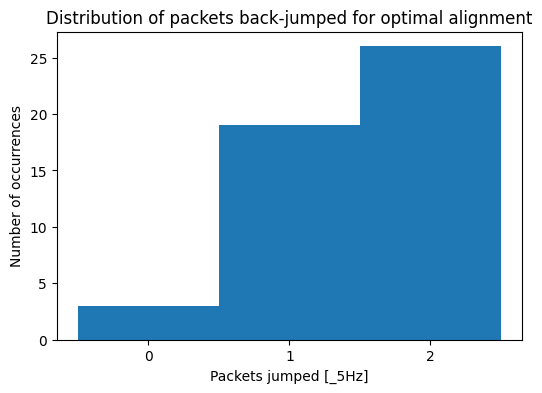

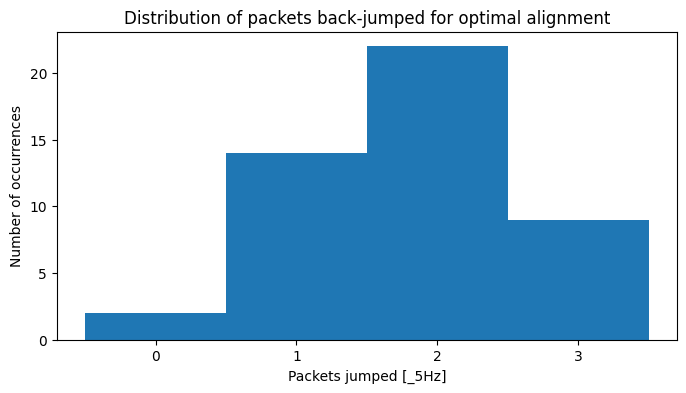

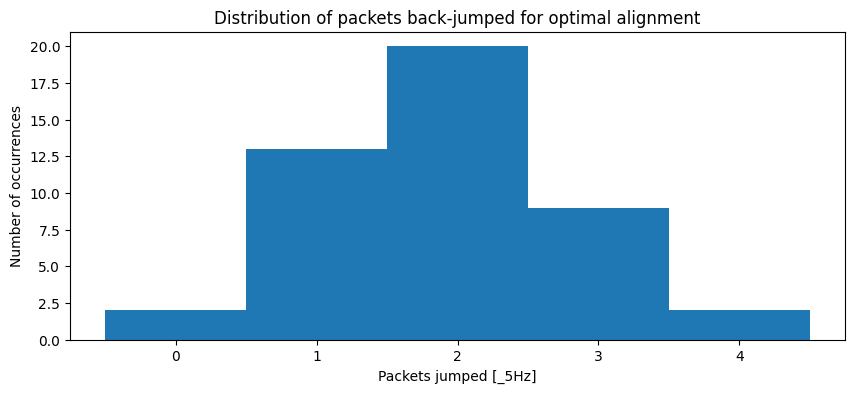

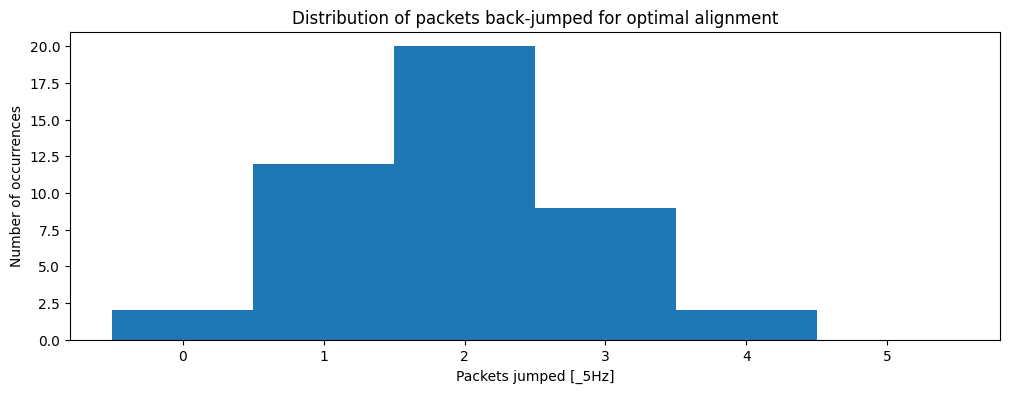

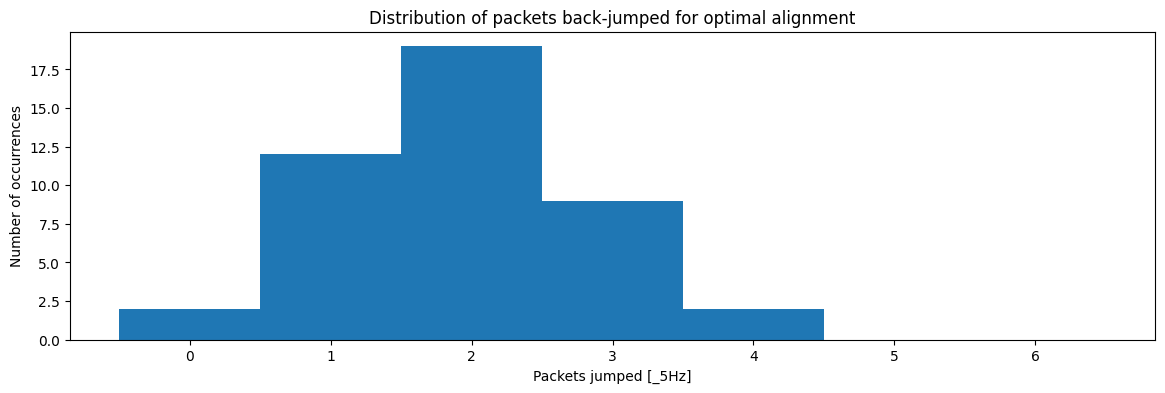

Sliced dataframe number:1
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston  Stonex_status
105  2023-05-03 15:09:46.317  2023-05-03 15:09:46.6     -144.79  -97.136169         -47.653824              2
106  2023-05-03 15:09:46.418  2023-05-03 15:09:46.6     -143.97  -96.810295         -47.159706              2
107  2023-05-03 15:09:46.516  2023-05-03 15:09:46.8     -143.14  -96.810295         -46.329704              2
108  2023-05-03 15:09:46.585  2023-05-03 15:09:46.8     -142.18  -96.082680         -46.097313              2
109   2023-05-03 15:09:46.75  2023-05-03 15:09:47.0     -138.47  -96.082680         -42.387321              2
..                       ...                    ...         ...         ...                ...            ...
155   2023-05-03 15:09:51.33  2023-05-03 15:09:51.6       99.51  147.416794         -47.906792              2
156  2023-05-03 15:09:51.434  2023-05-03 15:09:51.8       99.97  147.416794         -47.446793

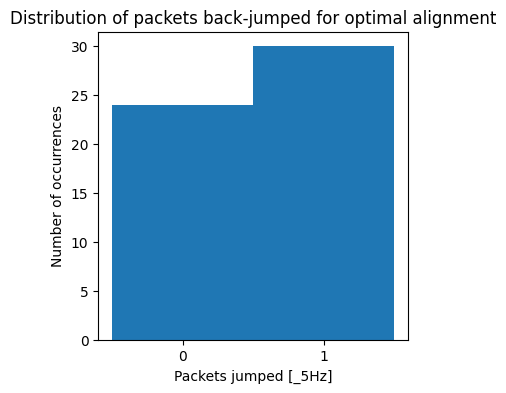

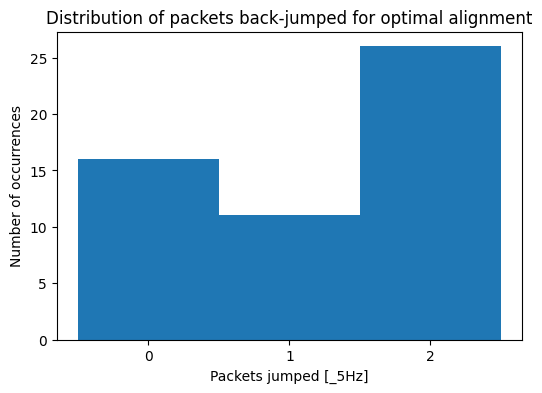

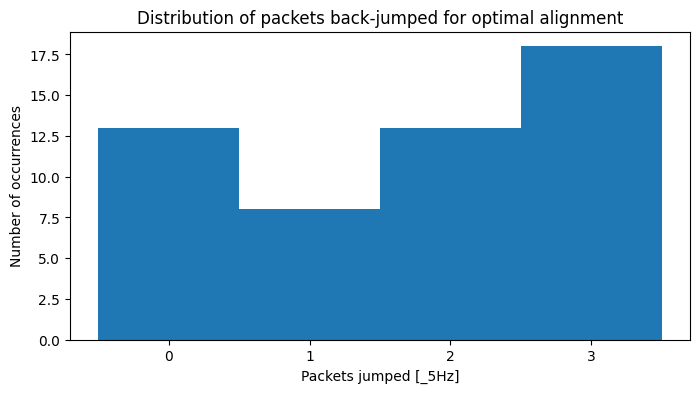

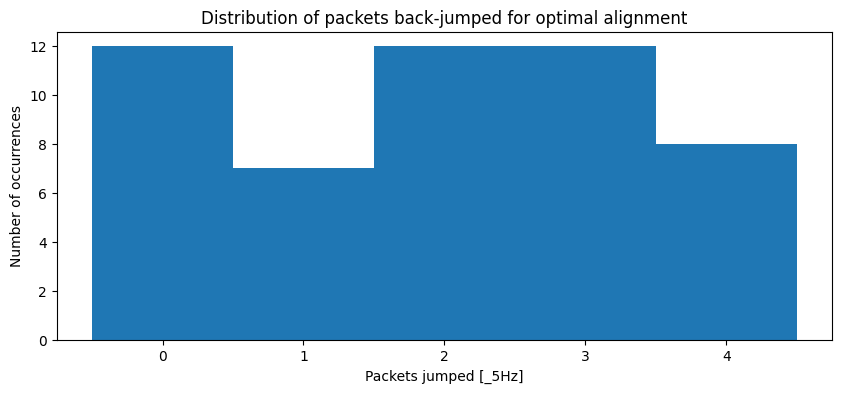

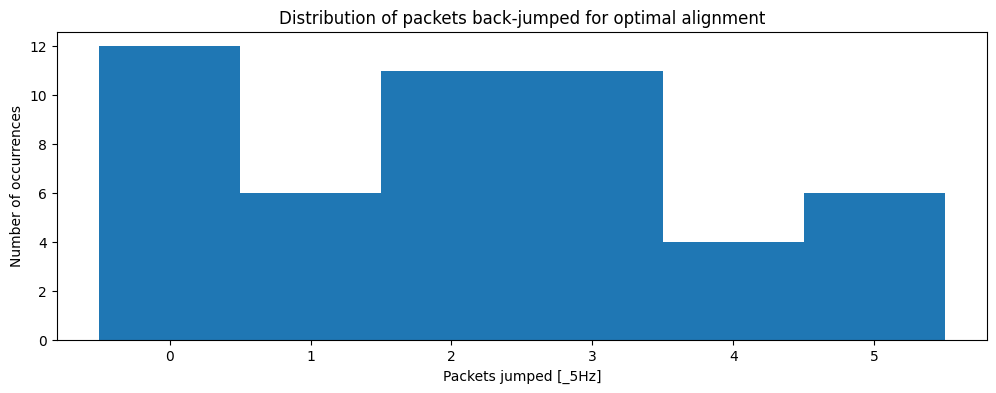

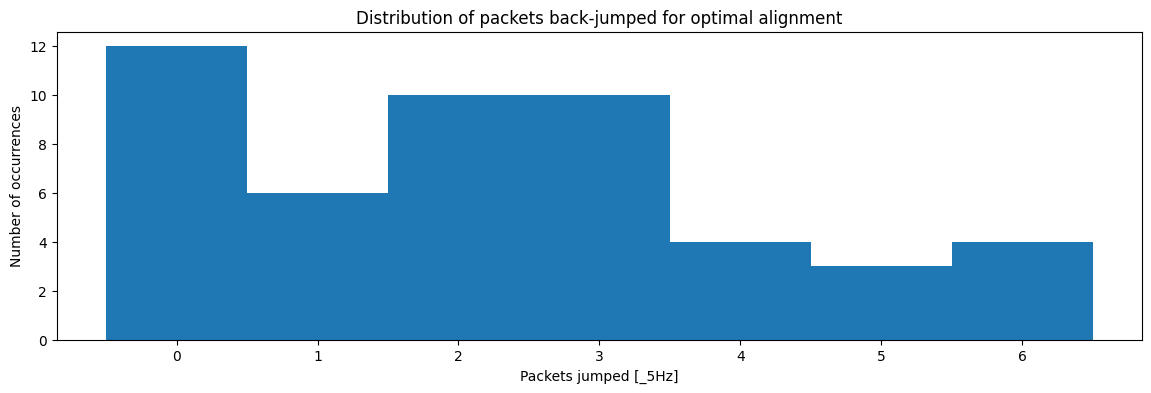

In [260]:
plot_histograms_of_the_day("files/2023_5_3", "_5Hz", [(55, 105), (105, 160)], [2, 3, 4, 5, 6, 7], True) #TODO: Fix and use the automatic range here

### 1.2.2 25 Hz

Original input dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston  Stonex_status
0    2023-05-03 15:09:15.603  2023-05-03 15:09:15.8      -44.67    7.734663         -52.404661              2
1     2023-05-03 15:09:15.62  2023-05-03 15:09:15.8      -44.78    7.734663         -52.514662              2
2    2023-05-03 15:09:15.645  2023-05-03 15:09:15.8      -45.00    7.734663         -52.734663              2
3    2023-05-03 15:09:15.679  2023-05-03 15:09:15.8      -45.30    7.734663         -53.034662              2
4    2023-05-03 15:09:15.716  2023-05-03 15:09:15.8      -45.62    7.734663         -53.354662              2
..                       ...                    ...         ...         ...                ...            ...
439  2023-05-03 15:09:30.244  2023-05-03 15:09:30.4       19.31   63.179451         -43.869452              2
440  2023-05-03 15:09:30.279  2023-05-03 15:09:30.6       19.87   63.179451         -4

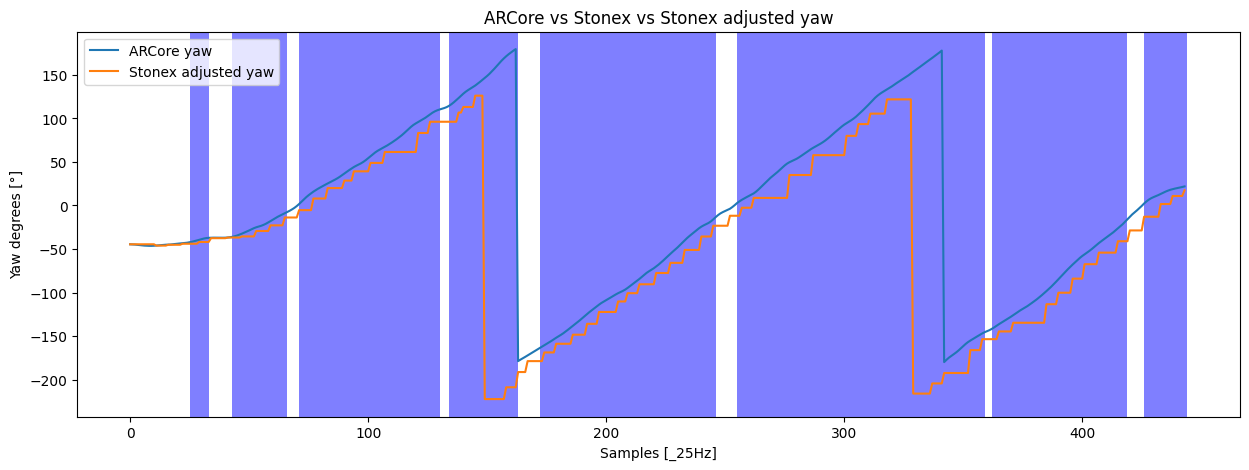

Moved frame list(len:334)
Fixed frame list(len:346)
Moved frame interval list(len:39): [(18, 28), (32, 52), (67, 74), (77, 83), (86, 103), (145, 163), (194, 202), (209, 213), (215, 213), (217, 219), (221, 223), (225, 227), (230, 232), (243, 263), (299, 311), (317, 320), (350, 360), (362, 365), (368, 365), (374, 386), (398, 404), (411, 418), (420, 424), (426, 437), (439, 441), (449, 469), (471, 476), (503, 512), (514, 515), (557, 568), (571, 574), (580, 593), (602, 603), (606, 611), (618, 632), (635, 648), (651, 657), (660, 665), (668, 665)]
Moved frame merged interval list(len:10): [(18, 52), (67, 103), (145, 163), (194, 232), (243, 263), (299, 320), (350, 386), (398, 476), (503, 515), (557, 665)]


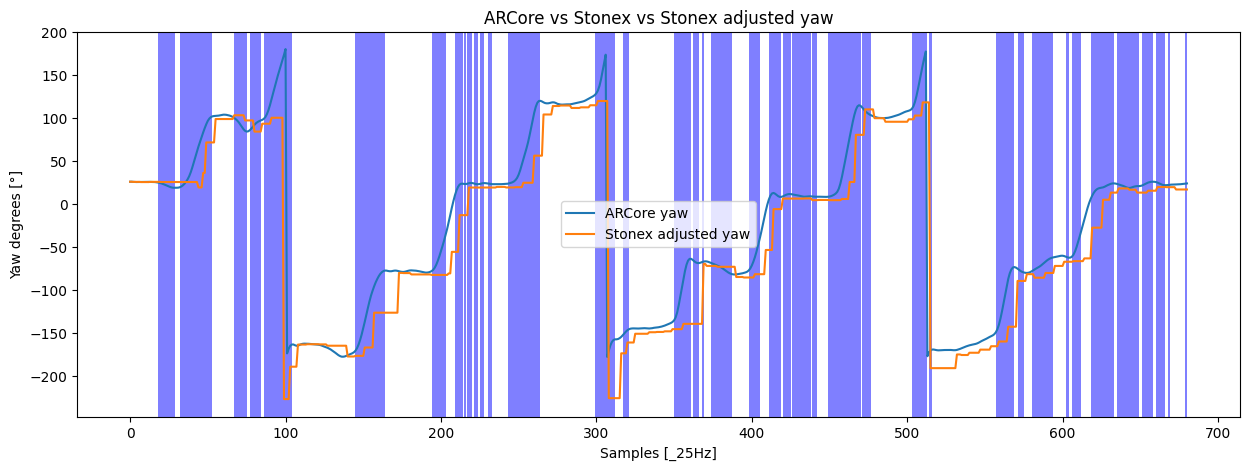

In [15]:
interesting_intervals_25hz = find_steep_ranges_of_the_day("files/2023_5_3", "_25Hz", 1, 10, True)

In [266]:
interesting_intervals_25hz[0]

[(25, 32), (43, 129), (134, 162), (172, 358), (362, 443)]

Original input dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston  Stonex_status
0    2023-05-03 15:09:15.603  2023-05-03 15:09:15.8      -44.67    7.734663         -52.404661              2
1     2023-05-03 15:09:15.62  2023-05-03 15:09:15.8      -44.78    7.734663         -52.514662              2
2    2023-05-03 15:09:15.645  2023-05-03 15:09:15.8      -45.00    7.734663         -52.734663              2
3    2023-05-03 15:09:15.679  2023-05-03 15:09:15.8      -45.30    7.734663         -53.034662              2
4    2023-05-03 15:09:15.716  2023-05-03 15:09:15.8      -45.62    7.734663         -53.354662              2
..                       ...                    ...         ...         ...                ...            ...
439  2023-05-03 15:09:30.244  2023-05-03 15:09:30.4       19.31   63.179451         -43.869452              2
440  2023-05-03 15:09:30.279  2023-05-03 15:09:30.6       19.87   63.179451         -4

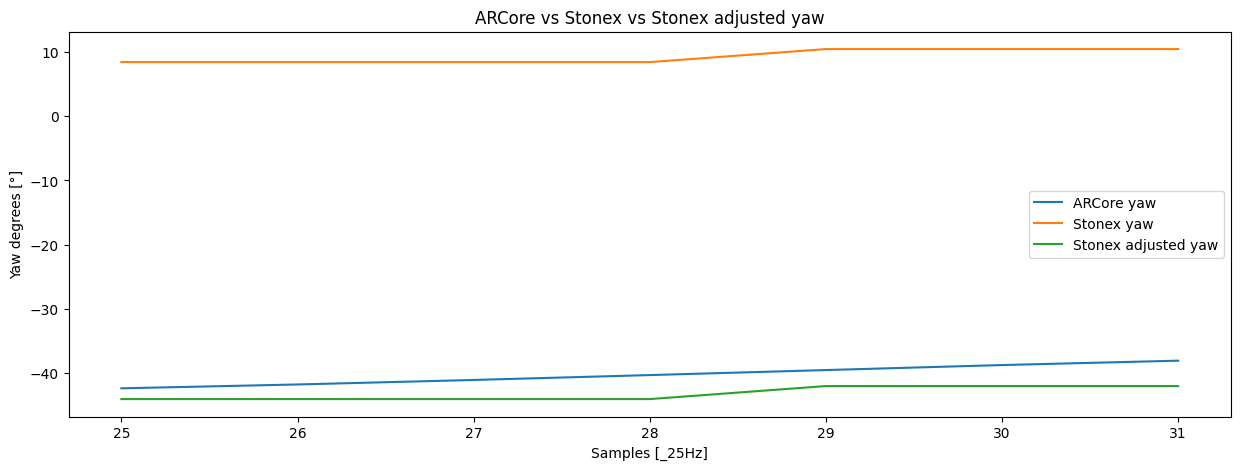

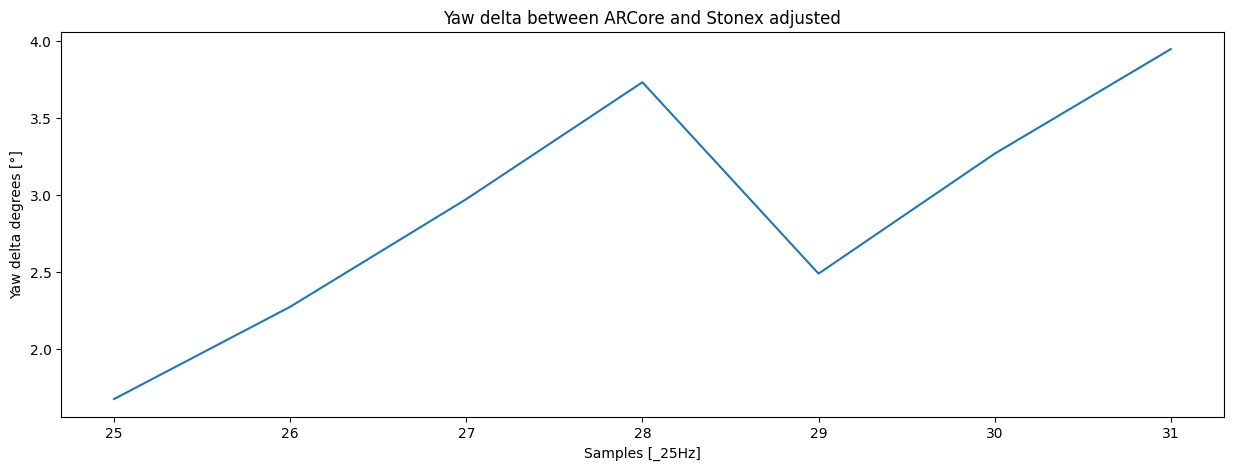

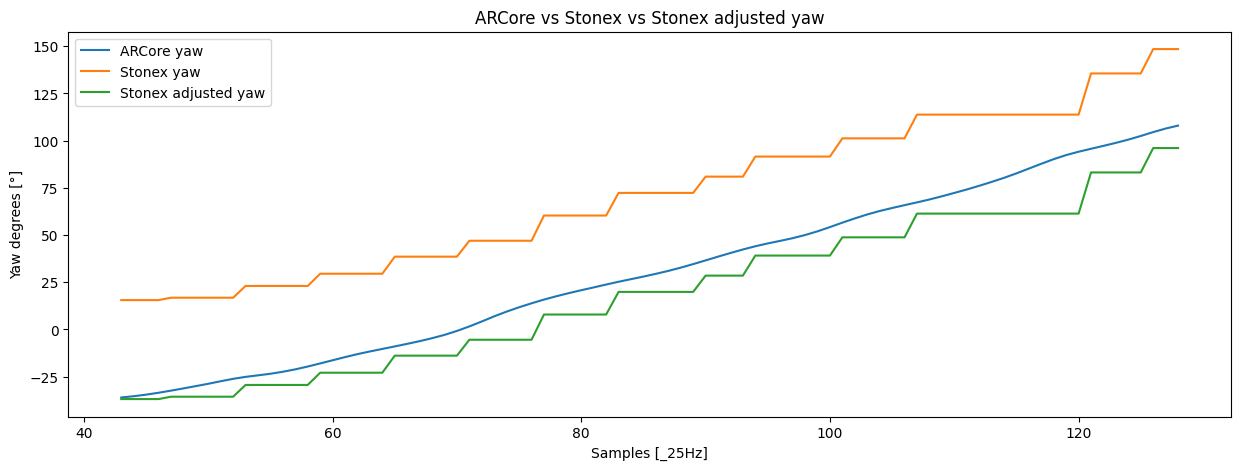

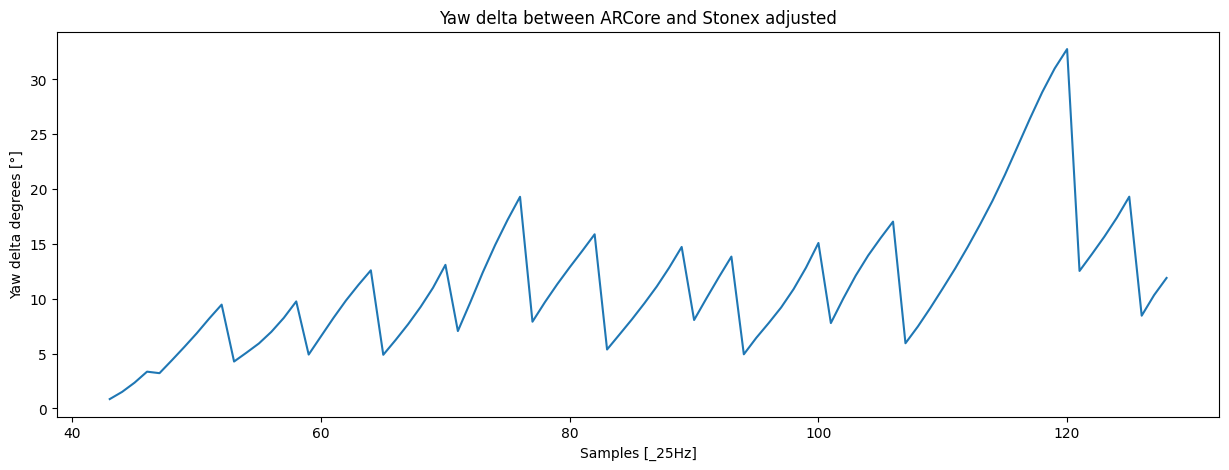

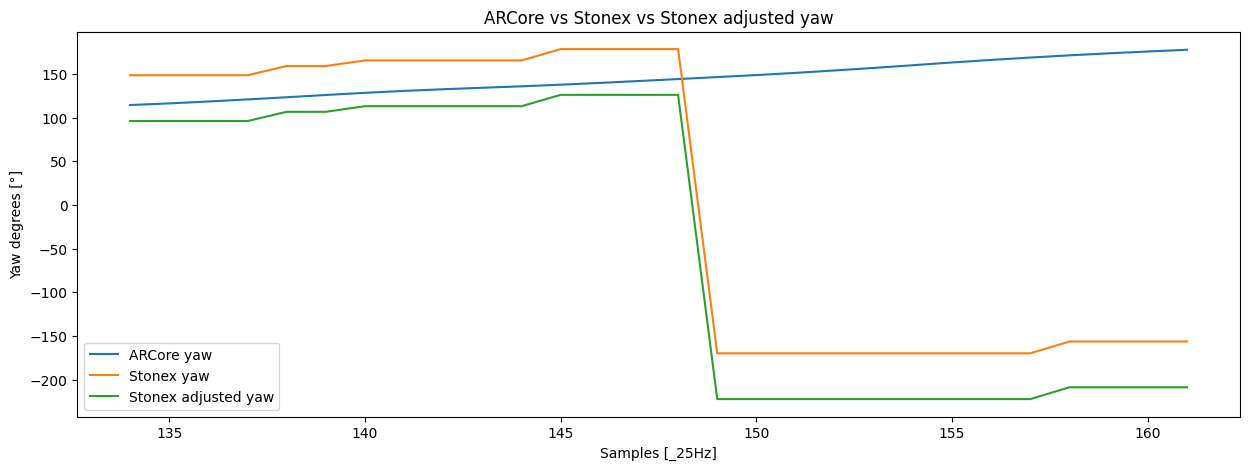

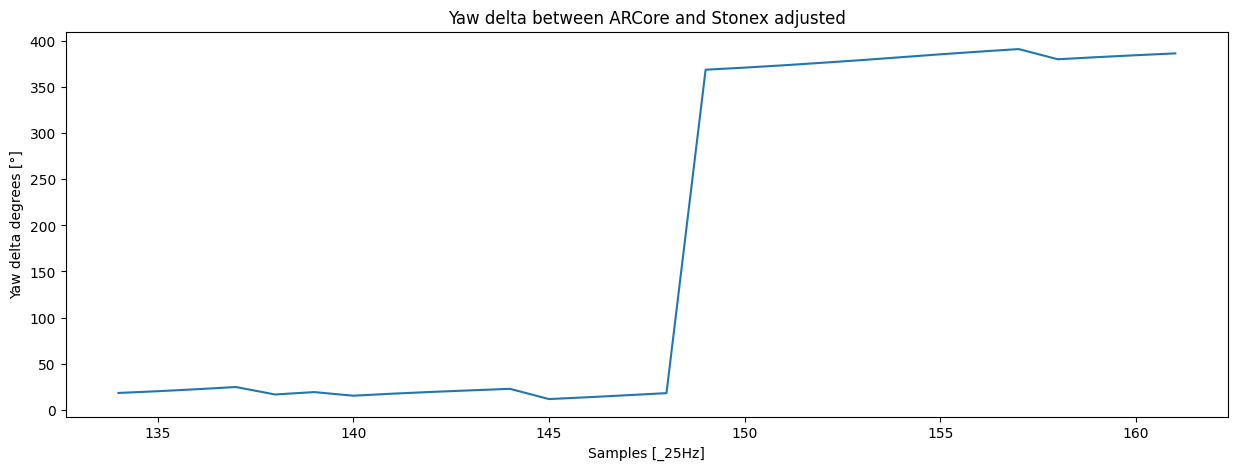

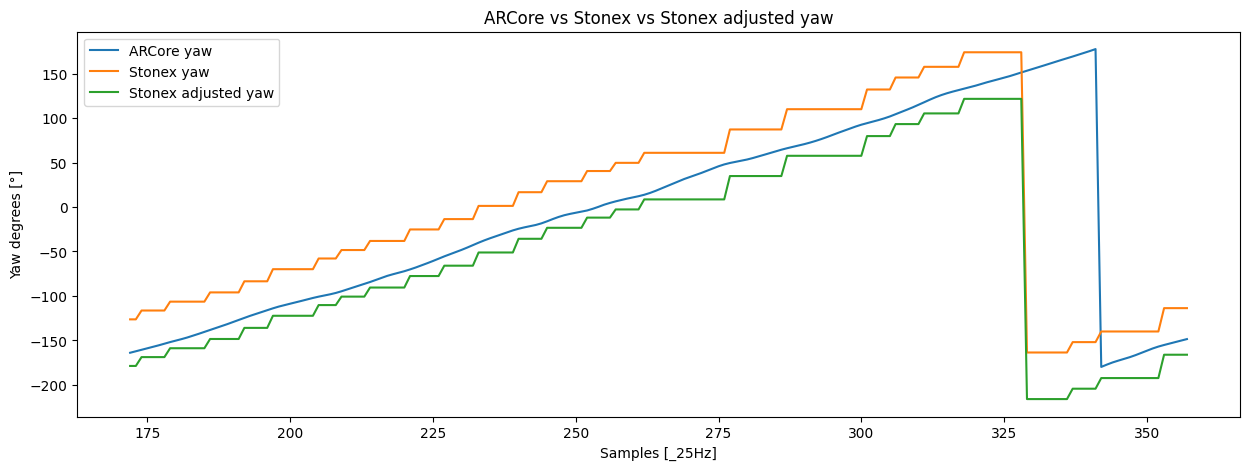

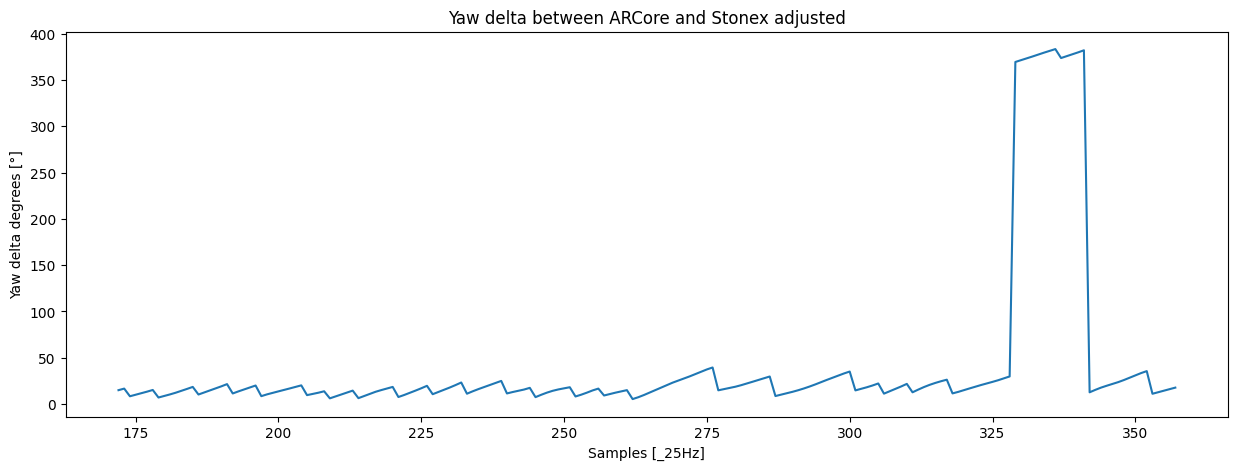

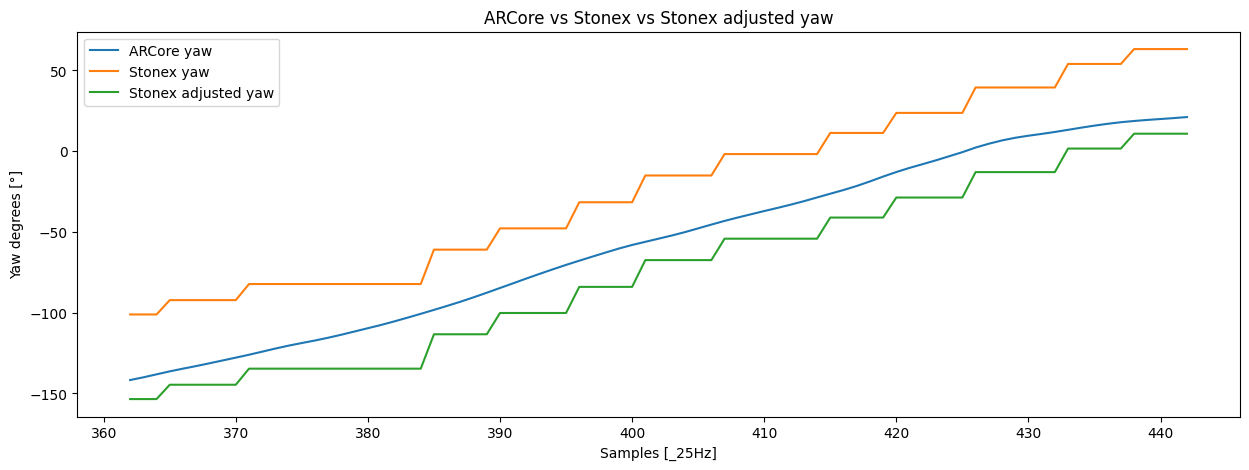

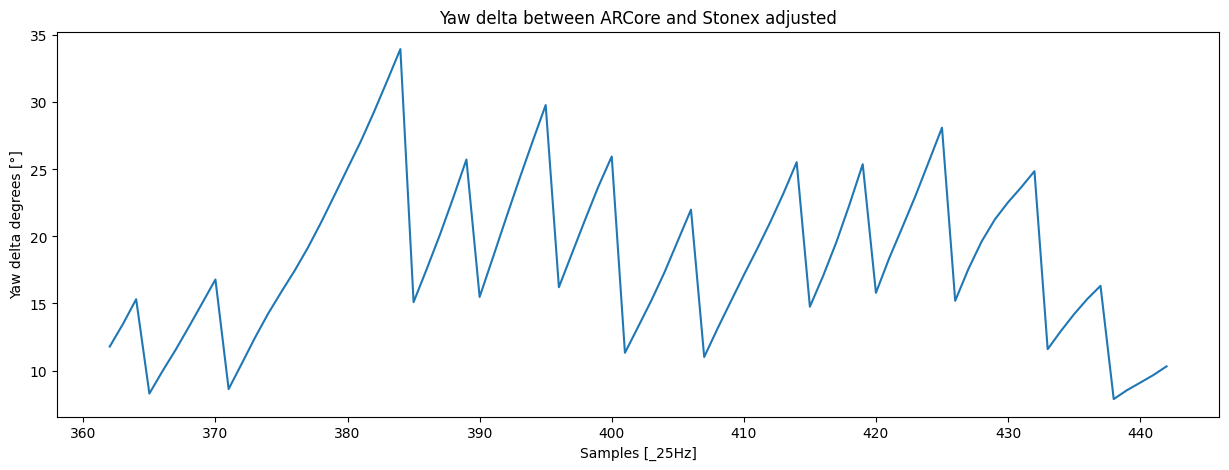

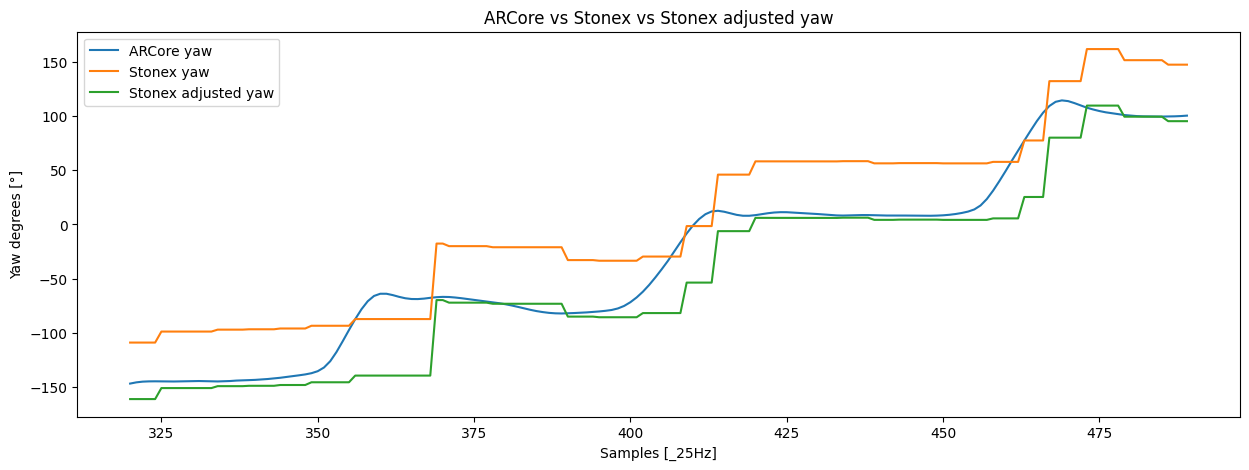

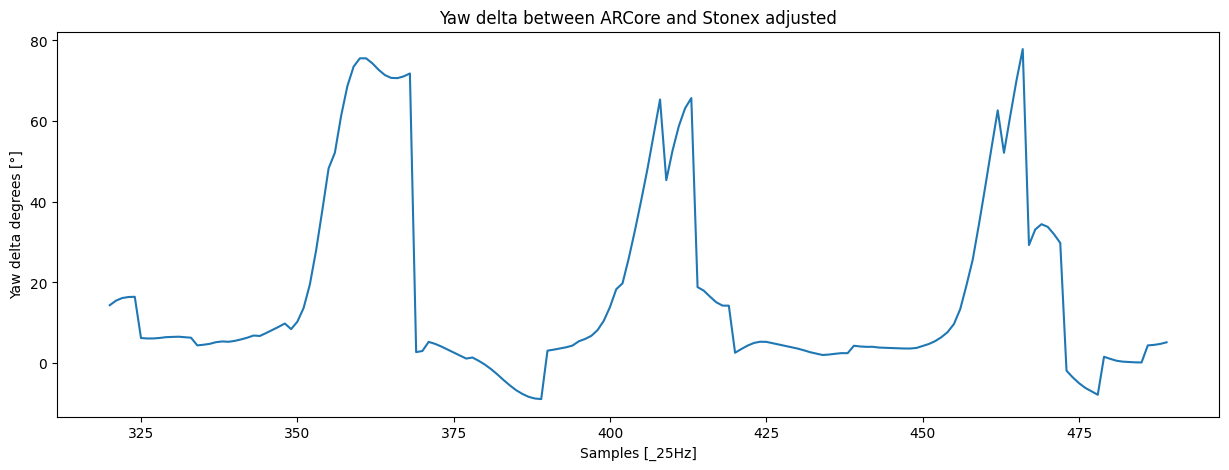

In [268]:
plot_yaw_charts_of_the_day("files/2023_5_3", "_25Hz", [interesting_intervals_25hz[0], [(320, 490)]], True) # (180, 320) //We keep a constant range for second chart since for now the computed ranges are very noisy

# 2.0 MANUAL ANALYSIS

## 2.1 Analysis on date 2023_5_2 (1 file)
### Mixture of movements
#### Measurements specific for the yaw with a continuous movement have been carried on in the day of 2023_5_2 at 5Hz

Original input dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston
0    2023-05-02 16:50:07.186  2023-05-02 16:50:07.6      -41.68 -111.863098          70.183098
1    2023-05-02 16:50:07.186  2023-05-02 16:50:07.6      -41.68 -111.902199          70.222199
2    2023-05-02 16:50:07.351  2023-05-02 16:50:07.8      -41.74 -111.902199          70.162197
3    2023-05-02 16:50:07.448  2023-05-02 16:50:07.8      -41.65 -111.906616          70.256614
4    2023-05-02 16:50:07.579  2023-05-02 16:50:08.0      -41.67 -111.906616          70.236618
..                       ...                    ...         ...         ...                ...
849  2023-05-02 16:51:35.595  2023-05-02 16:51:36.0       44.02  -26.716978          70.736978
850  2023-05-02 16:51:35.737  2023-05-02 16:51:36.2       45.89  -26.716978          72.606977
851  2023-05-02 16:51:35.837  2023-05-02 16:51:36.2       47.75  -24.455702          72.205702
852  2023-05-02 

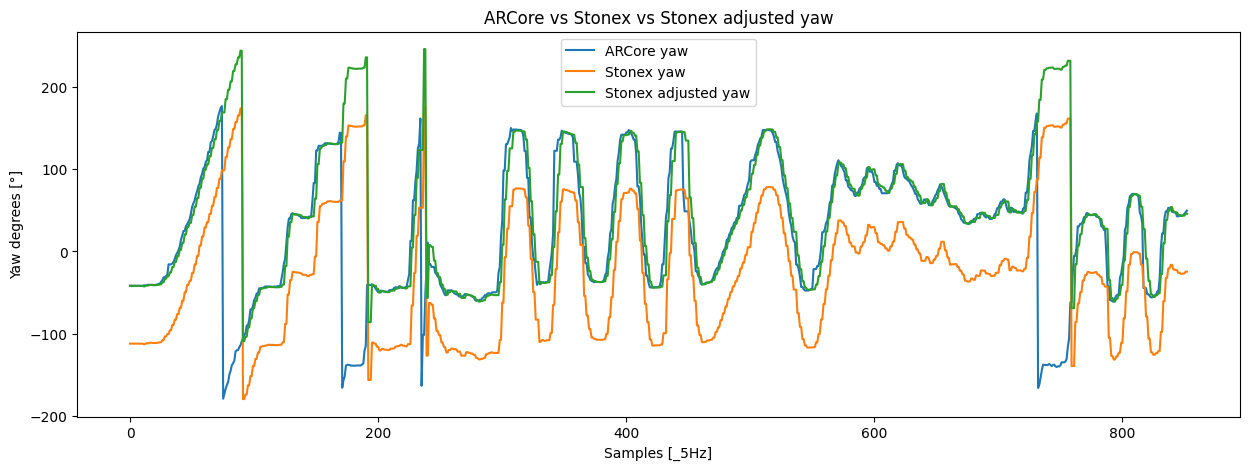

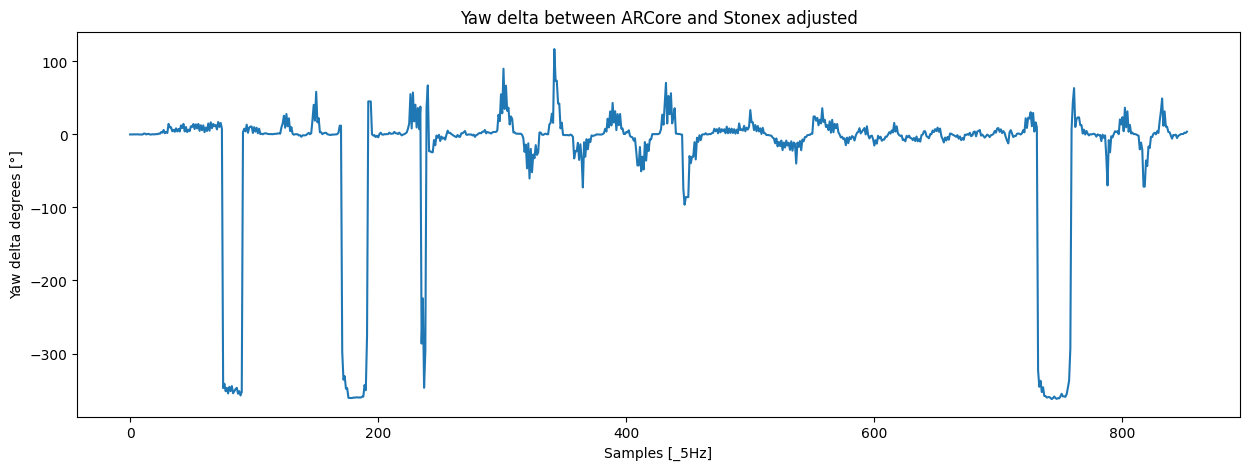

In [20]:
plot_yaw_charts_of_the_day("files/2023_5_2", "_5Hz", [[(0,0)]], True)

Original input dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston
0    2023-05-02 16:50:07.186  2023-05-02 16:50:07.6      -41.68 -111.863098          70.183098
1    2023-05-02 16:50:07.186  2023-05-02 16:50:07.6      -41.68 -111.902199          70.222199
2    2023-05-02 16:50:07.351  2023-05-02 16:50:07.8      -41.74 -111.902199          70.162197
3    2023-05-02 16:50:07.448  2023-05-02 16:50:07.8      -41.65 -111.906616          70.256614
4    2023-05-02 16:50:07.579  2023-05-02 16:50:08.0      -41.67 -111.906616          70.236618
..                       ...                    ...         ...         ...                ...
849  2023-05-02 16:51:35.595  2023-05-02 16:51:36.0       44.02  -26.716978          70.736978
850  2023-05-02 16:51:35.737  2023-05-02 16:51:36.2       45.89  -26.716978          72.606977
851  2023-05-02 16:51:35.837  2023-05-02 16:51:36.2       47.75  -24.455702          72.205702
852  2023-05-02 

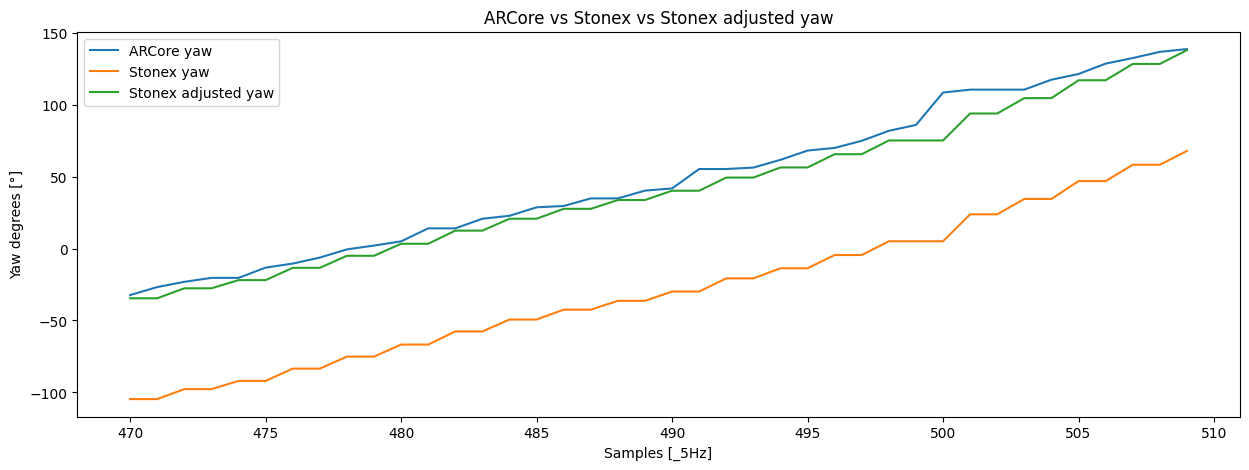

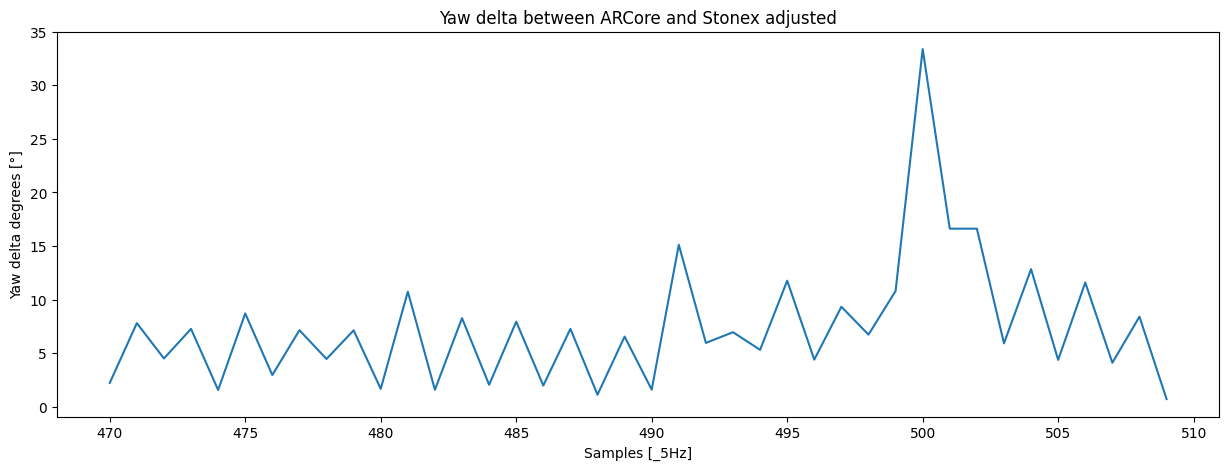

In [35]:
plot_yaw_charts_of_the_day("files/2023_5_2", "_5Hz", [[(470, 510)]], True)


Processed 1 files ['yaw_comparison_16-50-7.csv'] from folder 'files/2023_5_2/yaw_comparison_5Hz' 
Sliced dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston
470  2023-05-02 16:50:56.402  2023-05-02 16:50:56.8      -32.34 -104.741386          72.401386
471  2023-05-02 16:50:56.564  2023-05-02 16:50:57.0      -26.76 -104.741386          77.981386
472  2023-05-02 16:50:56.702  2023-05-02 16:50:57.0      -23.12  -97.805176          74.685175
473  2023-05-02 16:50:56.772  2023-05-02 16:50:57.2      -20.36  -97.805176          77.445175
474  2023-05-02 16:50:56.772  2023-05-02 16:50:57.2      -20.36  -92.105026          71.745025
..                       ...                    ...         ...         ...                ...
505  2023-05-02 16:51:00.017  2023-05-02 16:51:00.4      121.58   47.027954          74.552048
506  2023-05-02 16:51:00.144  2023-05-02 16:51:00.6      128.80   47.027954          81.772049
507  2023-05-02 16:5

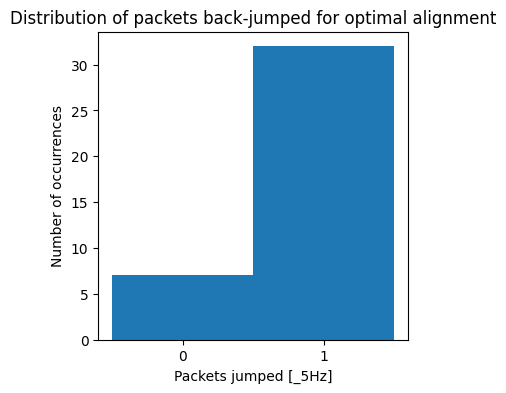

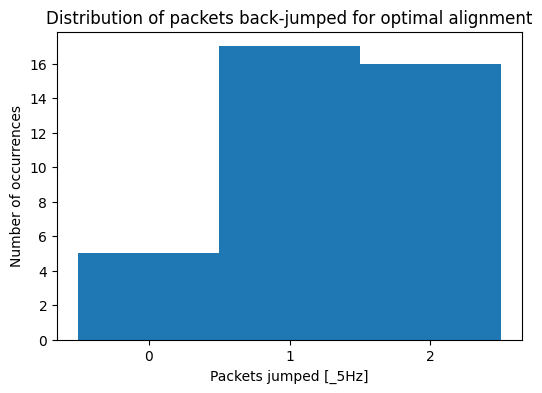

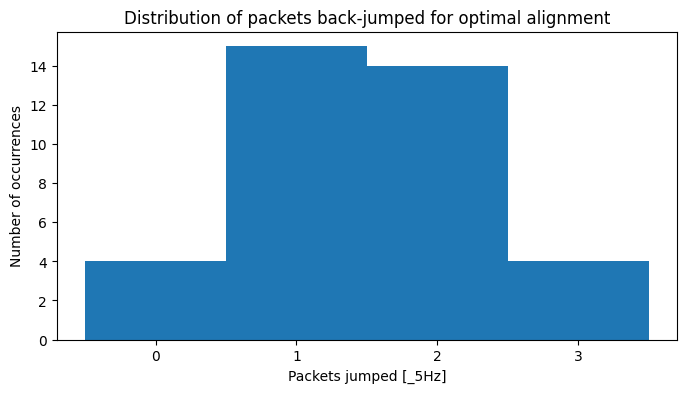

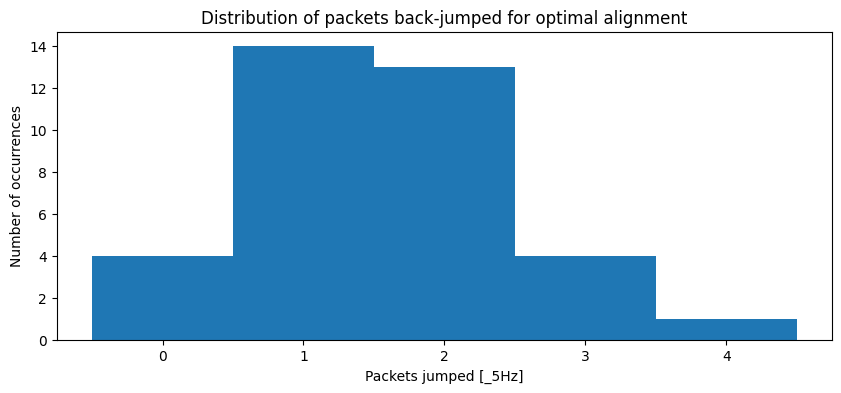

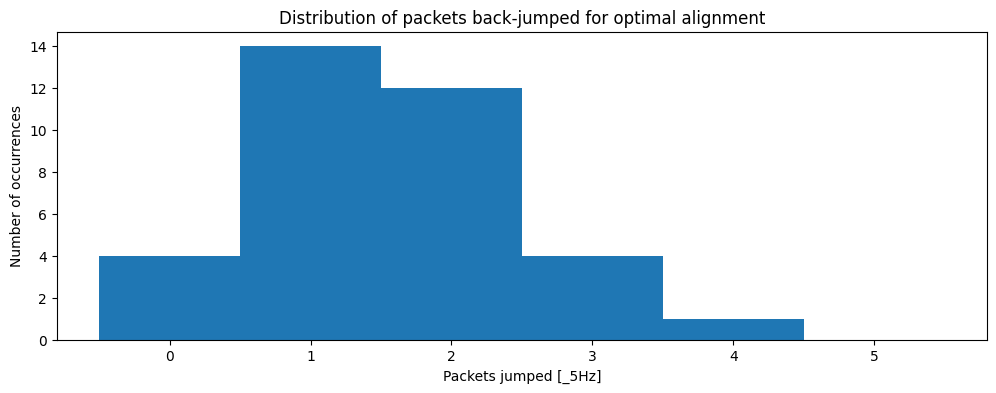

In [36]:
plot_histograms_of_the_day("files/2023_5_2", "_5Hz", [(470, 510)], [2, 3, 4, 5, 6], True, False, False)

## 2.2 Analysis on date 2023_5_3, (2 files).
### File 1: continuous rotation for 360 degrees, File 2: 90degrees turn, stop, repeat until closing the cycle (3 cycles done)
#### Measurements specific for the yaw with an intermittent movement have been carried on in the day of 2023_5_3 both at 5Hz and 25Hz

### 2.2.1 5HZ

Original input dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston  Stonex_status
0    2023-05-03 15:09:15.546  2023-05-03 15:09:15.8      -44.74    7.734663         -52.474665              2
1    2023-05-03 15:09:15.779  2023-05-03 15:09:16.0      -46.17    7.734663         -53.904661              2
2    2023-05-03 15:09:15.779  2023-05-03 15:09:16.0      -46.17    7.767914         -53.937912              2
3    2023-05-03 15:09:15.877  2023-05-03 15:09:16.2      -46.45    7.767914         -54.217915              2
4    2023-05-03 15:09:15.909  2023-05-03 15:09:16.2      -46.33    6.229918         -52.559920              2
..                       ...                    ...         ...         ...                ...            ...
139  2023-05-03 15:09:30.012  2023-05-03 15:09:30.2       11.85   53.979710         -42.129710              2
140  2023-05-03 15:09:30.112  2023-05-03 15:09:30.4       15.78   53.979710         -3

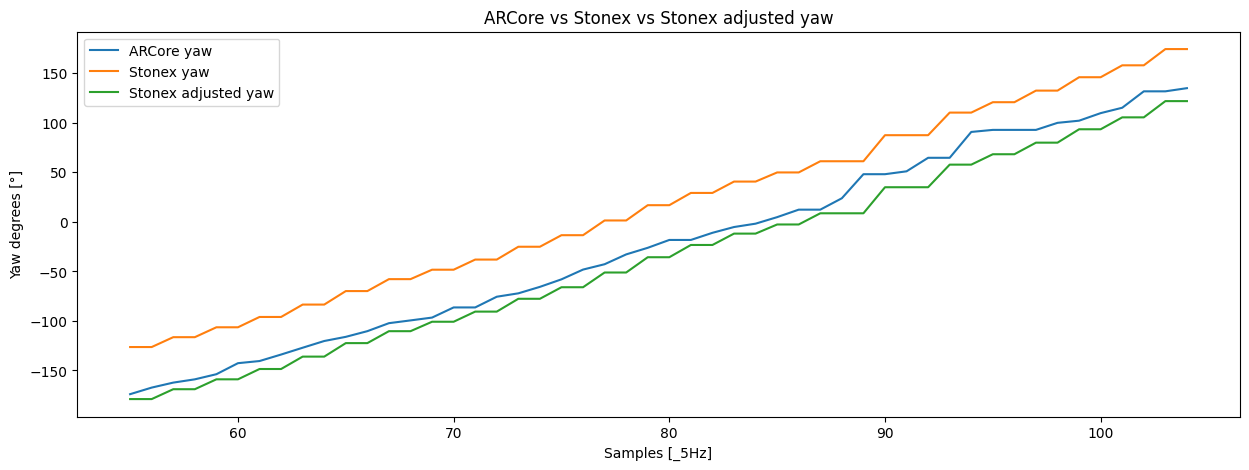

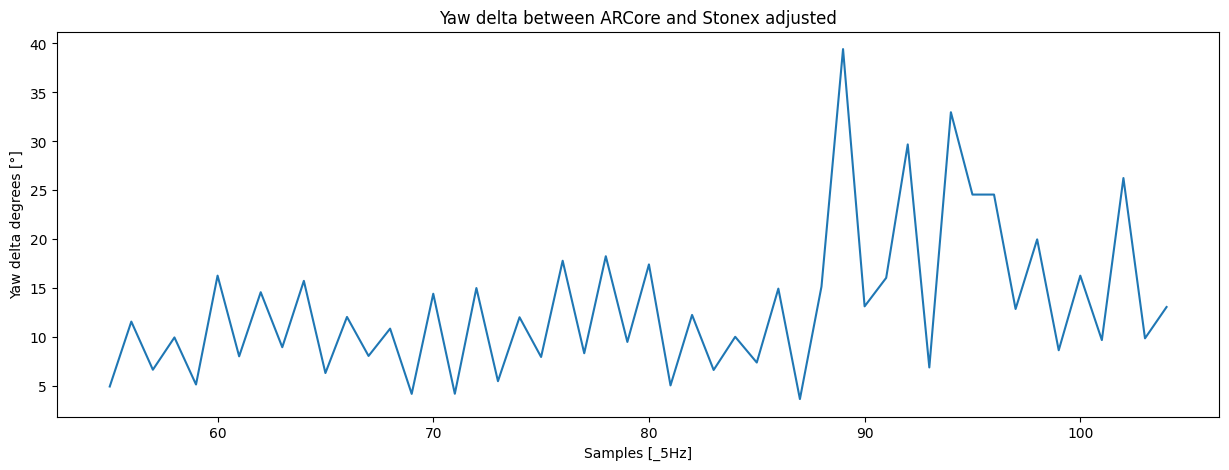

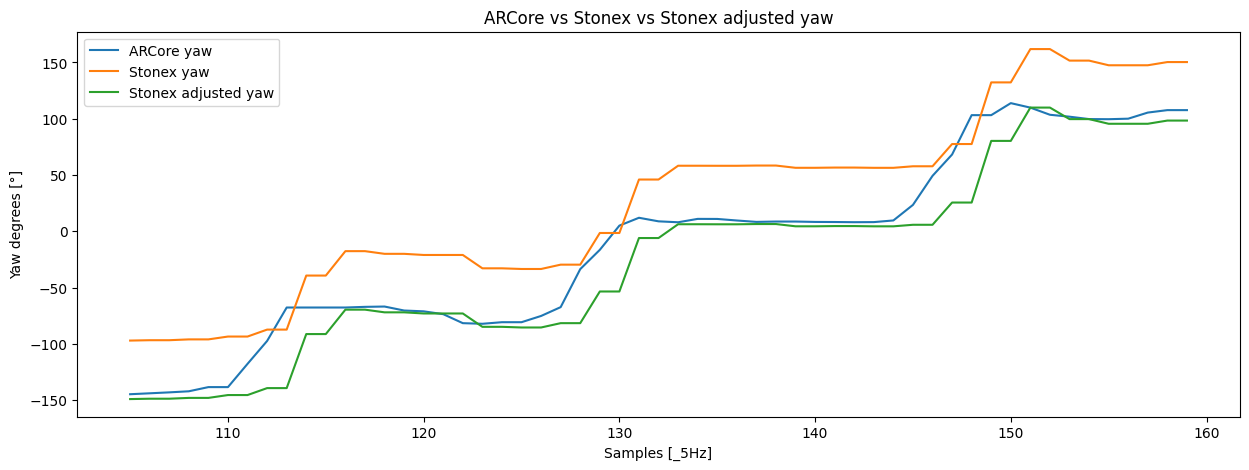

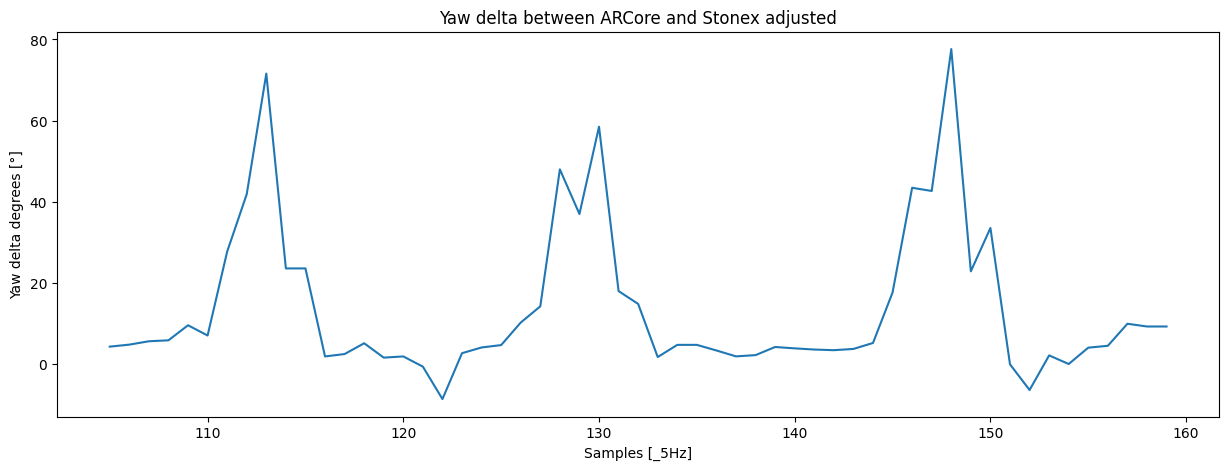

In [29]:
plot_yaw_charts_of_the_day("files/2023_5_3", "_5Hz", [[(55, 105)], [(105, 160)]], True)


Processed 2 files ['yaw_comparison_5Hz_15-9-15.csv', 'yaw_comparison_5Hz_15-9-35.csv'] from folder 'files/2023_5_3/yaw_comparison_5Hz' 
Sliced dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston  Stonex_status
55   2023-05-03 15:09:21.123  2023-05-03 15:09:21.4     -173.88 -126.356323         -47.523682              2
56   2023-05-03 15:09:21.255  2023-05-03 15:09:21.6     -167.25 -126.356323         -40.893677              2
57   2023-05-03 15:09:21.354  2023-05-03 15:09:21.6     -162.22 -116.409653         -45.810348              2
58   2023-05-03 15:09:21.421  2023-05-03 15:09:21.8     -158.92 -116.409653         -42.510345              2
59   2023-05-03 15:09:21.521  2023-05-03 15:09:21.8     -153.75 -106.431908         -47.318092              2
..                       ...                    ...         ...         ...                ...            ...
100  2023-05-03 15:09:25.867  2023-05-03 15:09:26.2      109.51  14

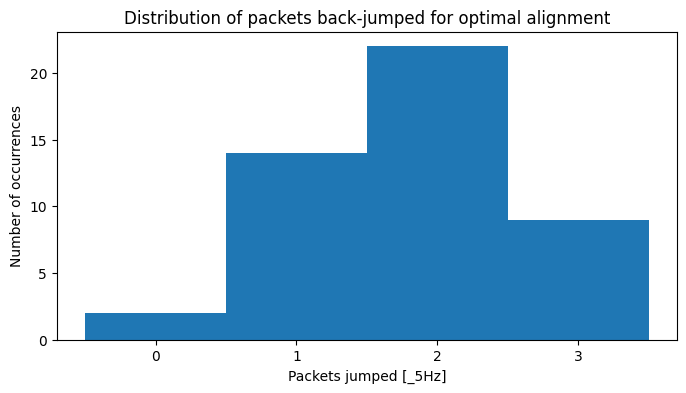

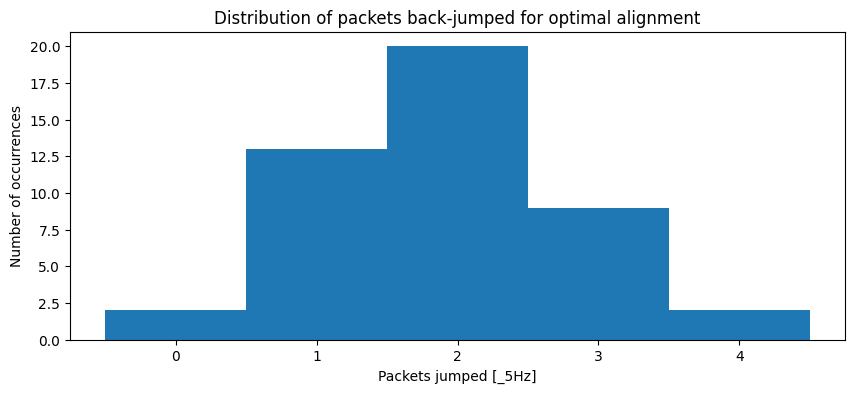

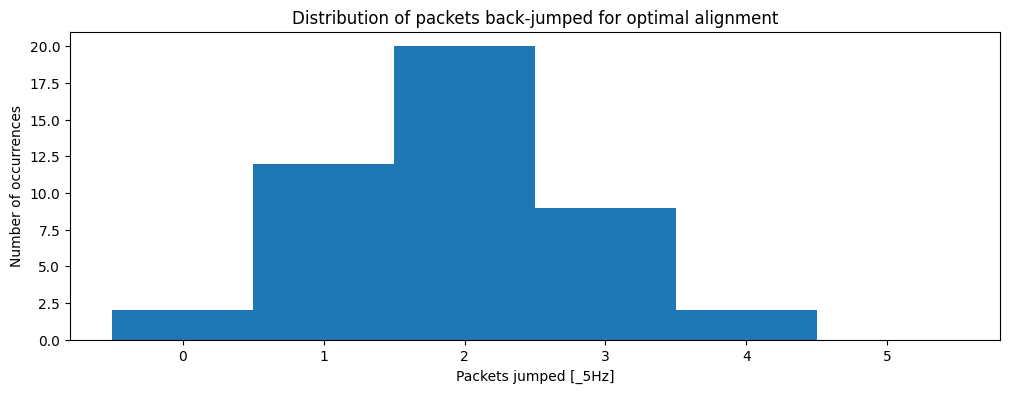

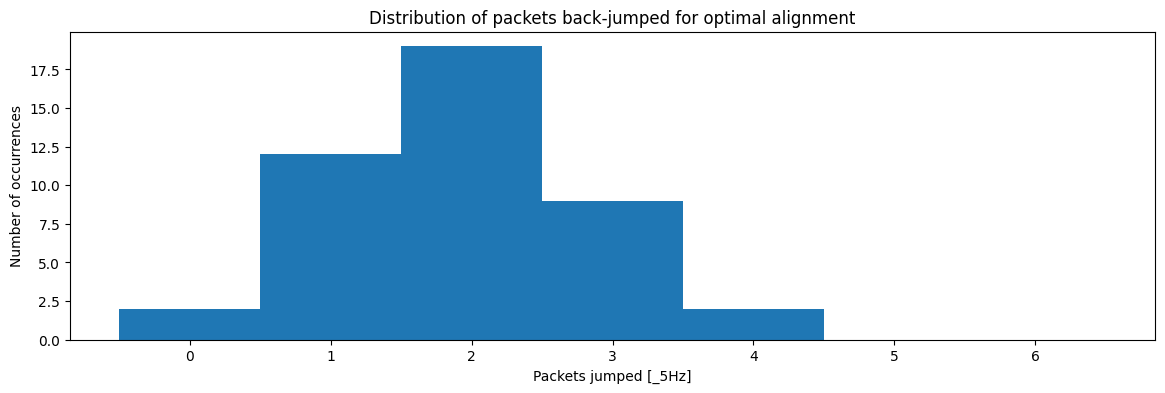

Sliced dataframe number:1
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston  Stonex_status
105  2023-05-03 15:09:46.317  2023-05-03 15:09:46.6     -144.79  -97.136169         -47.653824              2
106  2023-05-03 15:09:46.418  2023-05-03 15:09:46.6     -143.97  -96.810295         -47.159706              2
107  2023-05-03 15:09:46.516  2023-05-03 15:09:46.8     -143.14  -96.810295         -46.329704              2
108  2023-05-03 15:09:46.585  2023-05-03 15:09:46.8     -142.18  -96.082680         -46.097313              2
109   2023-05-03 15:09:46.75  2023-05-03 15:09:47.0     -138.47  -96.082680         -42.387321              2
..                       ...                    ...         ...         ...                ...            ...
155   2023-05-03 15:09:51.33  2023-05-03 15:09:51.6       99.51  147.416794         -47.906792              2
156  2023-05-03 15:09:51.434  2023-05-03 15:09:51.8       99.97  147.416794         -47.446793

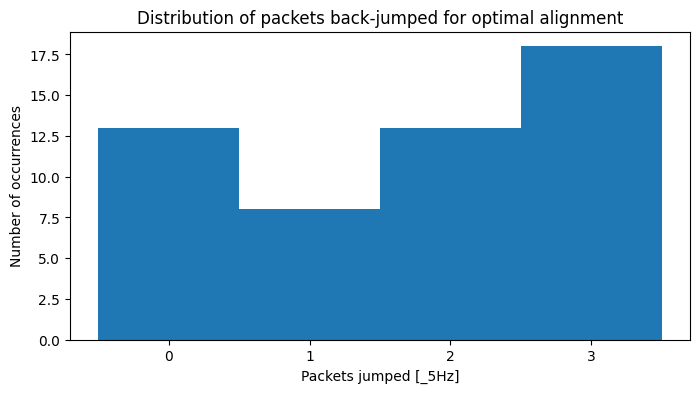

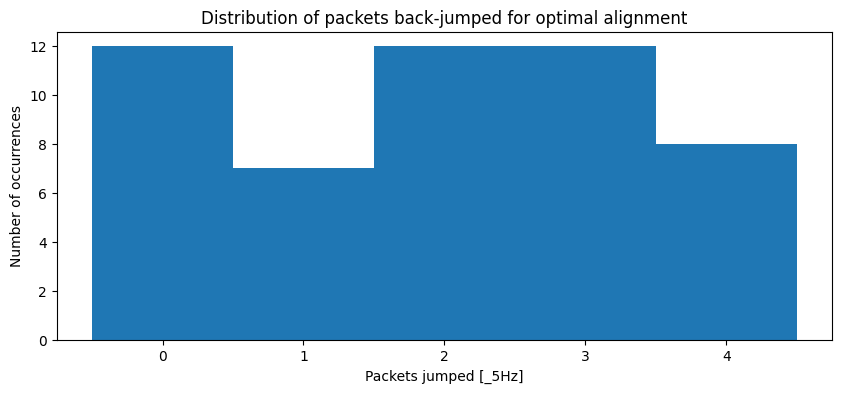

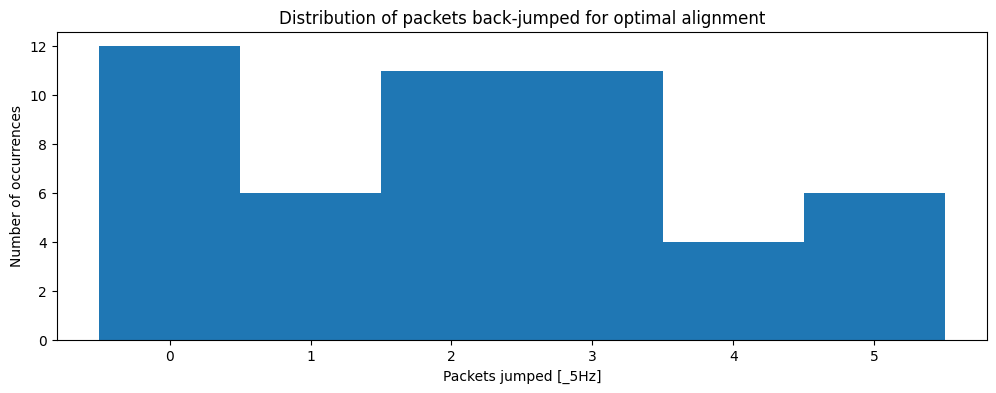

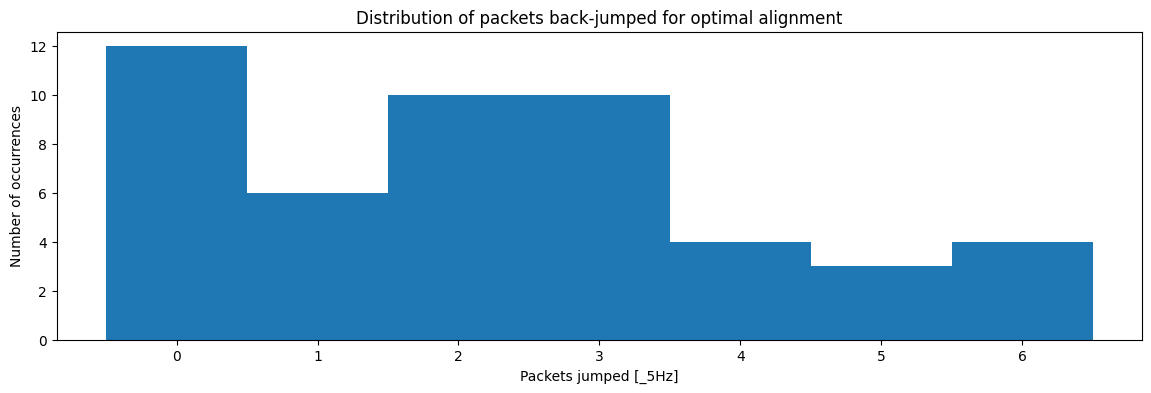

In [32]:
plot_histograms_of_the_day("files/2023_5_3", "_5Hz", [(55, 105), (105, 160)], [4,5,6,7], True)

### 2.2.2 25 Hz

Original input dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston  Stonex_status
0    2023-05-03 15:09:15.603  2023-05-03 15:09:15.8      -44.67    7.734663         -52.404661              2
1     2023-05-03 15:09:15.62  2023-05-03 15:09:15.8      -44.78    7.734663         -52.514662              2
2    2023-05-03 15:09:15.645  2023-05-03 15:09:15.8      -45.00    7.734663         -52.734663              2
3    2023-05-03 15:09:15.679  2023-05-03 15:09:15.8      -45.30    7.734663         -53.034662              2
4    2023-05-03 15:09:15.716  2023-05-03 15:09:15.8      -45.62    7.734663         -53.354662              2
..                       ...                    ...         ...         ...                ...            ...
439  2023-05-03 15:09:30.244  2023-05-03 15:09:30.4       19.31   63.179451         -43.869452              2
440  2023-05-03 15:09:30.279  2023-05-03 15:09:30.6       19.87   63.179451         -4

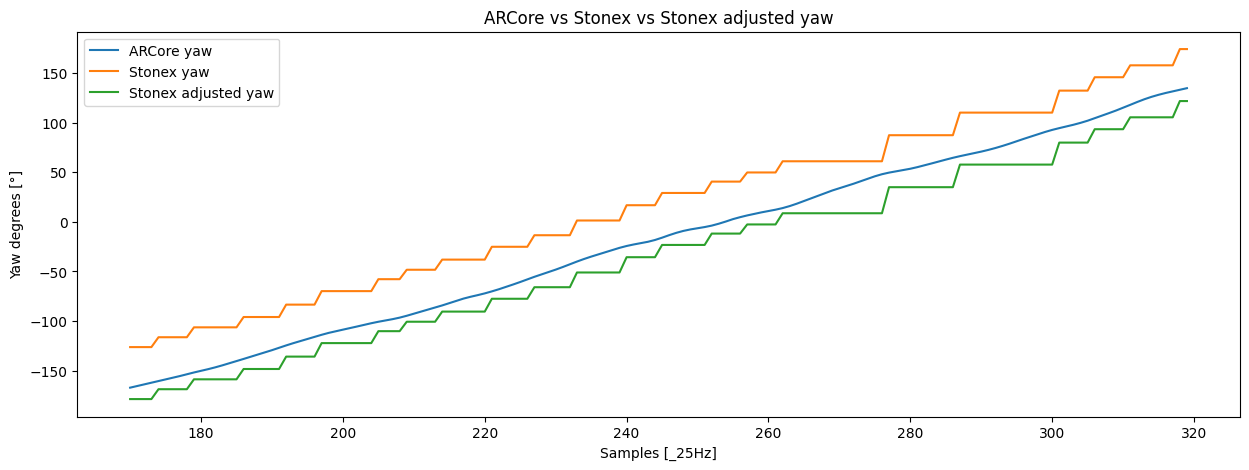

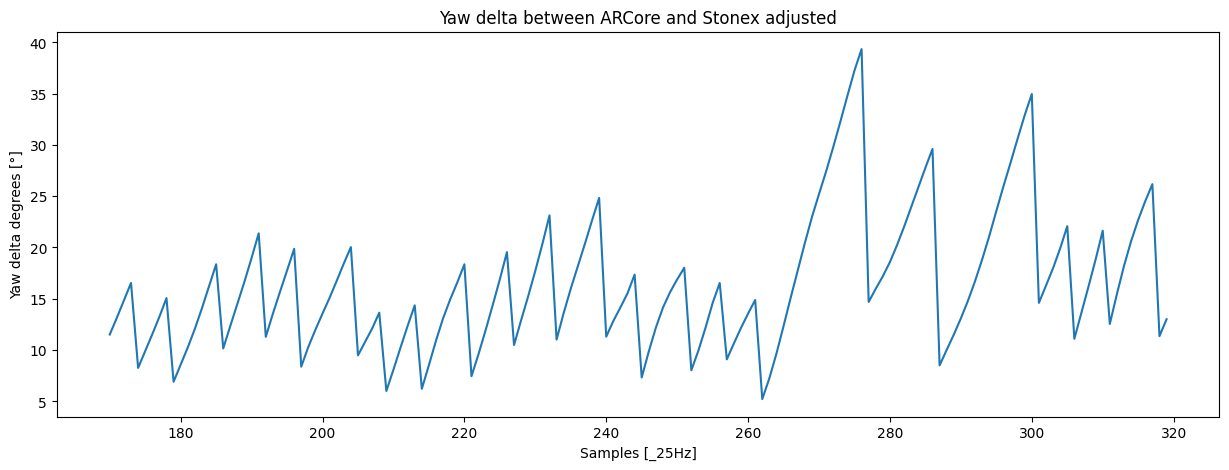

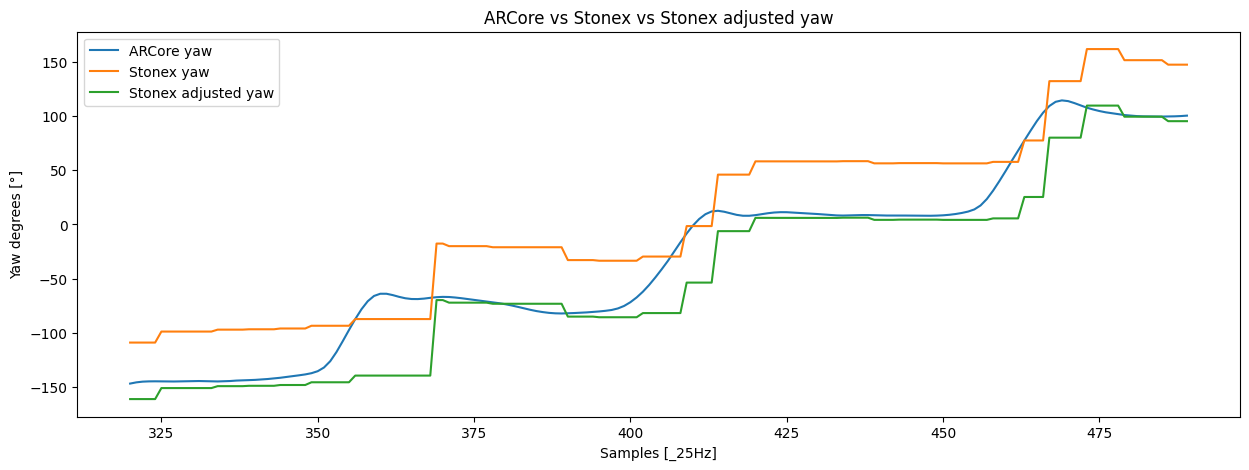

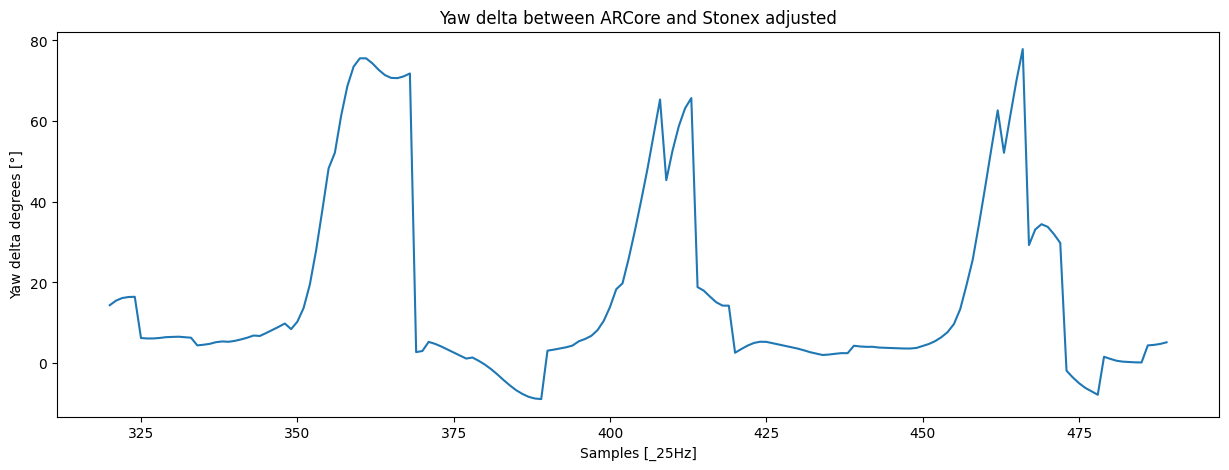

In [44]:
plot_yaw_charts_of_the_day("files/2023_5_3", "_25Hz", [[(170, 320)], [(320, 490)]], True)


Processed 2 files ['yaw_comparison_25Hz_15-9-15.csv', 'yaw_comparison_25Hz_15-9-35.csv'] from folder 'files/2023_5_3/yaw_comparison_25Hz' 
Sliced dataframe number:0
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston  Stonex_status
170  2023-05-03 15:09:21.255  2023-05-03 15:09:21.4     -167.25 -126.356323         -40.893677              2
171  2023-05-03 15:09:21.288  2023-05-03 15:09:21.6     -165.62 -126.356323         -39.263672              2
172   2023-05-03 15:09:21.32  2023-05-03 15:09:21.6     -163.92 -126.356323         -37.563675              2
173  2023-05-03 15:09:21.354  2023-05-03 15:09:21.6     -162.22 -126.356323         -35.863678              2
174  2023-05-03 15:09:21.387  2023-05-03 15:09:21.6     -160.56 -116.409653         -44.150345              2
..                       ...                    ...         ...         ...                ...            ...
315    2023-05-03 15:09:26.1  2023-05-03 15:09:26.2      128.01 

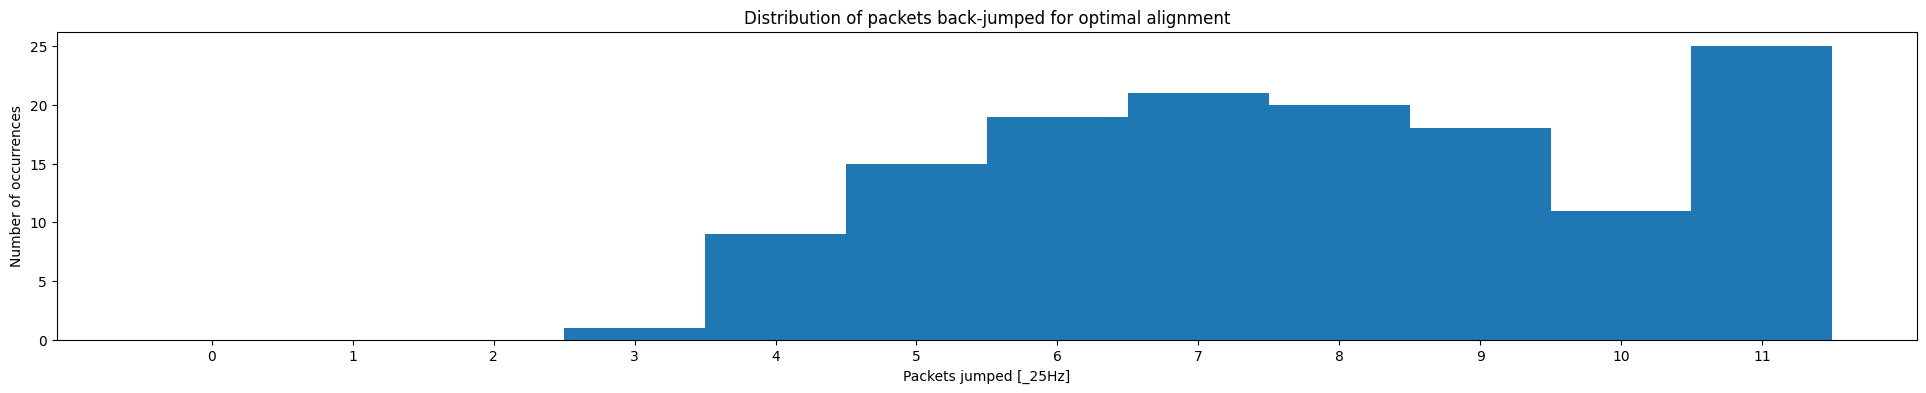

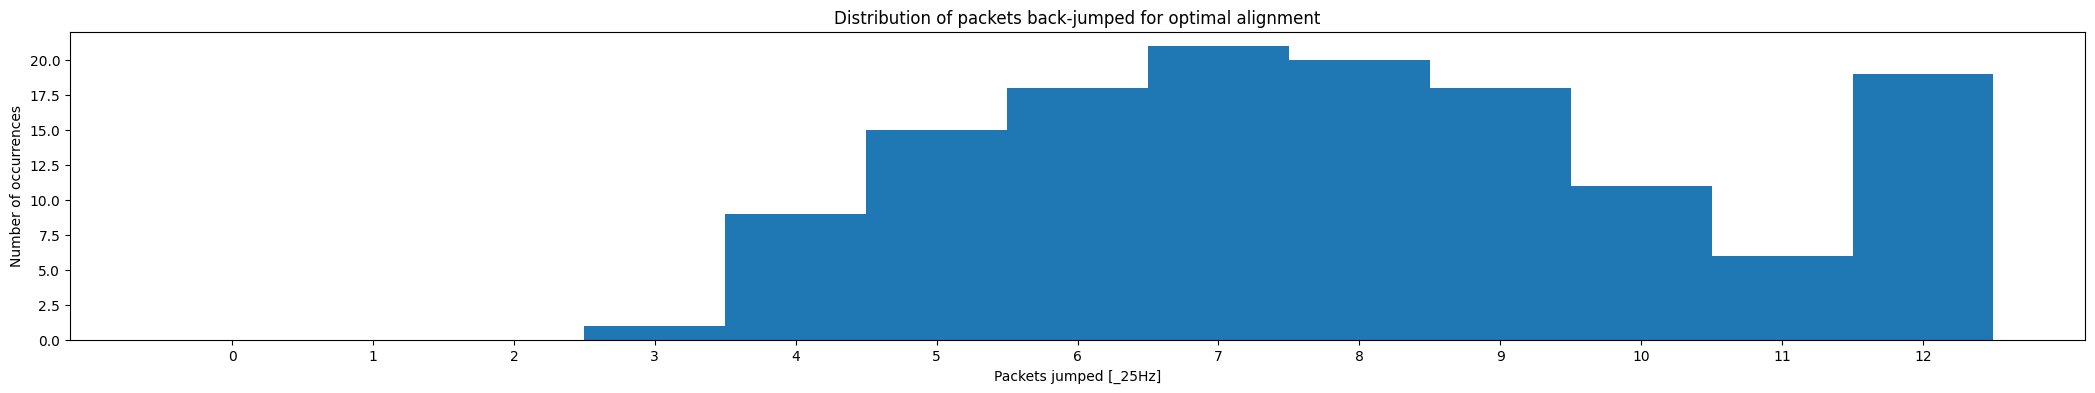

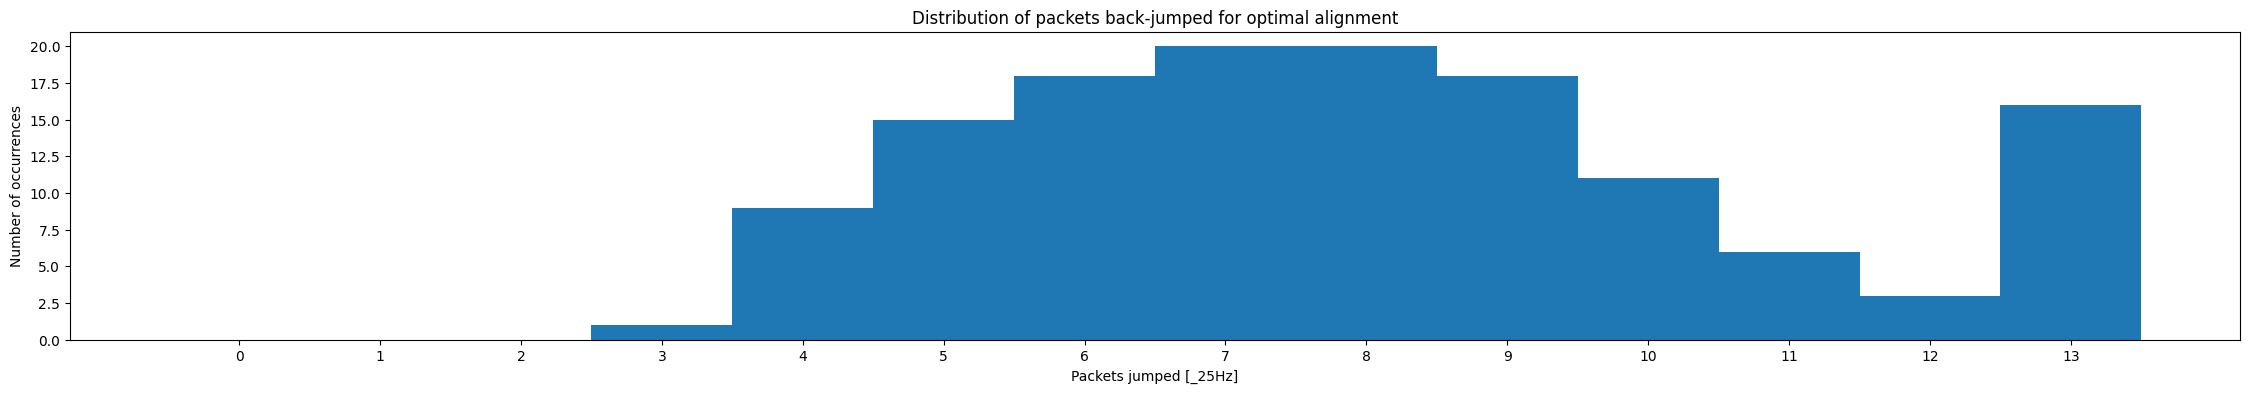

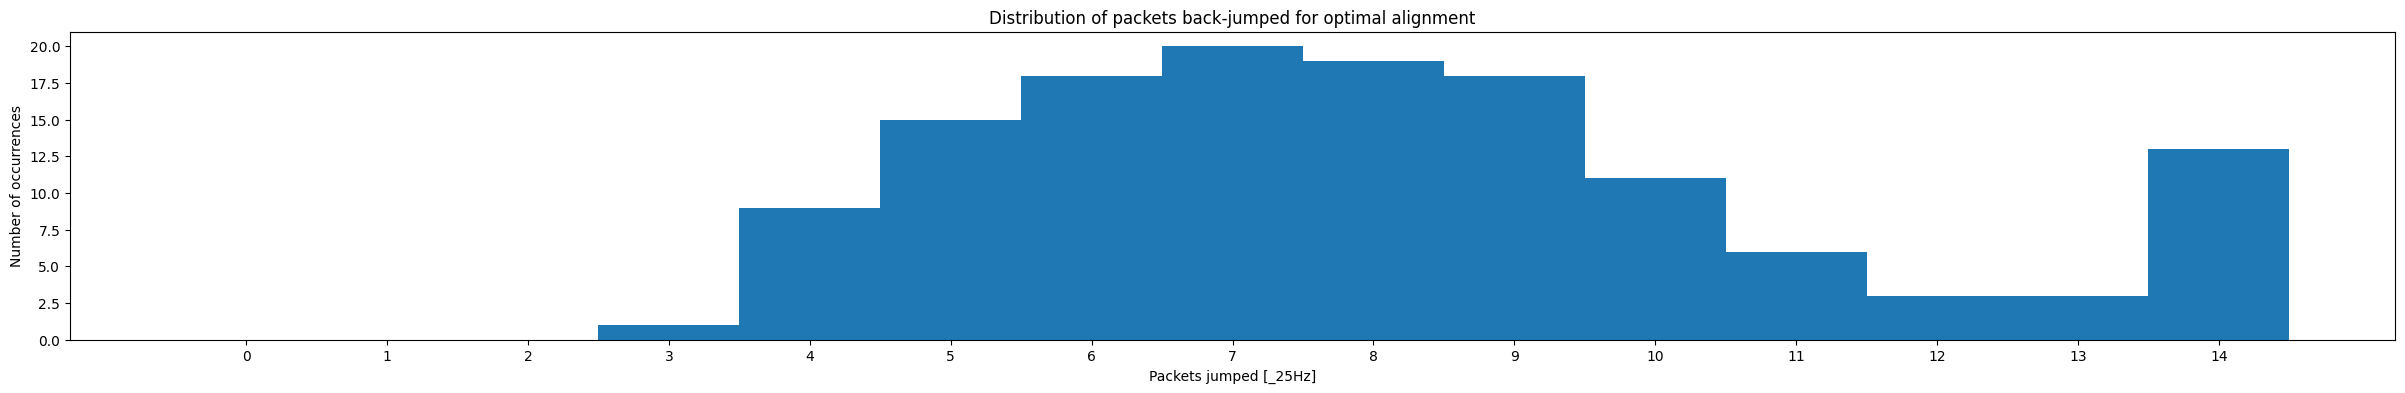

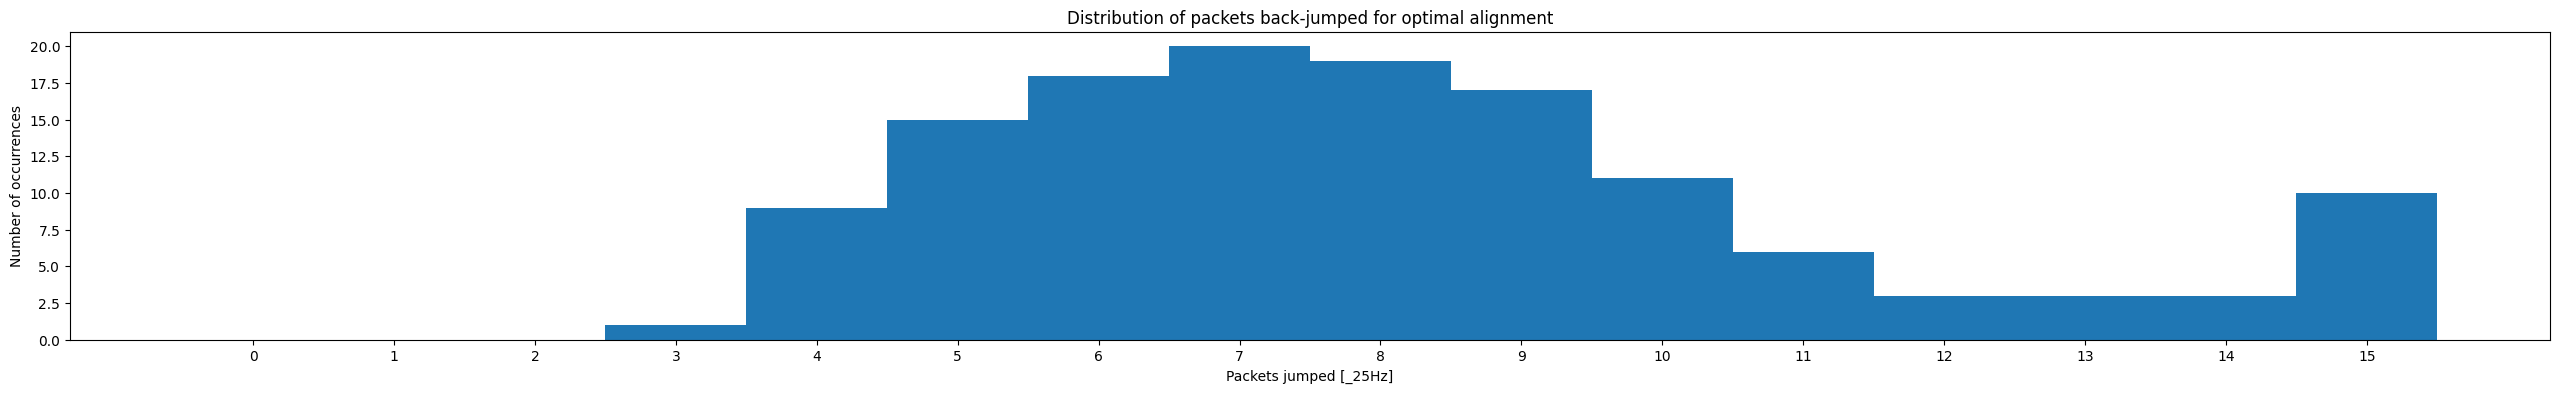

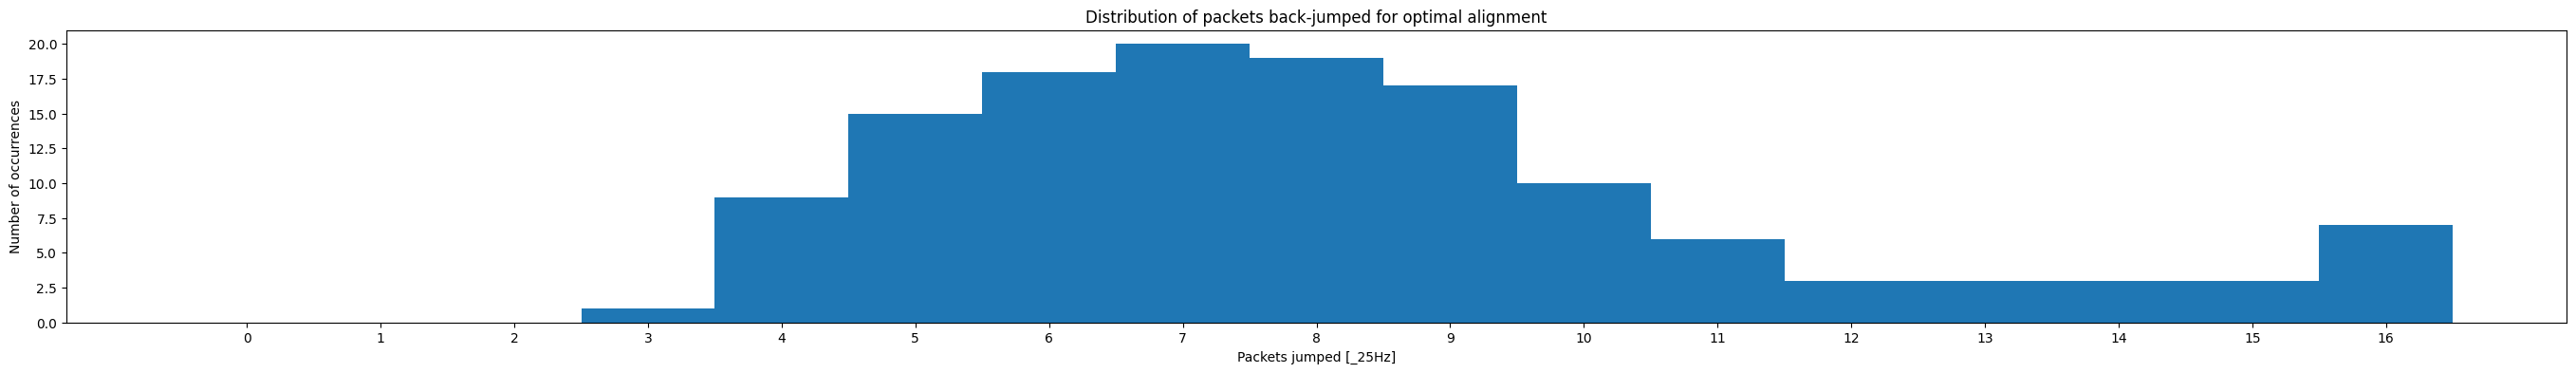

Sliced dataframe number:1
                Android_time       Stonex_gnss_time  ARCore_yaw  Stonex_yaw  Delta_yaw_AR_Ston  Stonex_status
320  2023-05-03 15:09:45.819  2023-05-03 15:09:46.0     -146.92 -109.071564         -37.848434              2
321  2023-05-03 15:09:45.849  2023-05-03 15:09:46.0     -145.79 -109.071564         -36.718429              2
322  2023-05-03 15:09:45.881  2023-05-03 15:09:46.0     -145.14 -109.071564         -36.068435              2
323   2023-05-03 15:09:45.92  2023-05-03 15:09:46.0     -144.89 -109.071564         -35.818435              2
324  2023-05-03 15:09:45.949  2023-05-03 15:09:46.0     -144.83 -109.071564         -35.758438              2
..                       ...                    ...         ...         ...                ...            ...
485   2023-05-03 15:09:51.33  2023-05-03 15:09:51.6       99.51  151.555557         -52.045555              2
486  2023-05-03 15:09:51.365  2023-05-03 15:09:51.6       99.60  147.416794         -47.816796

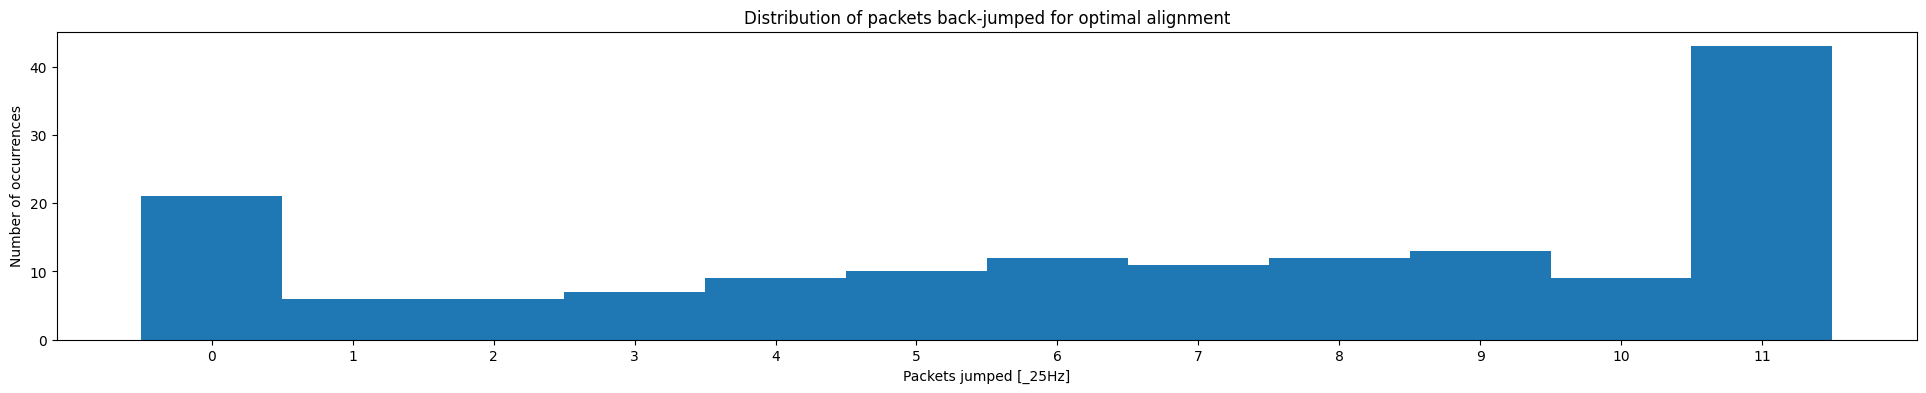

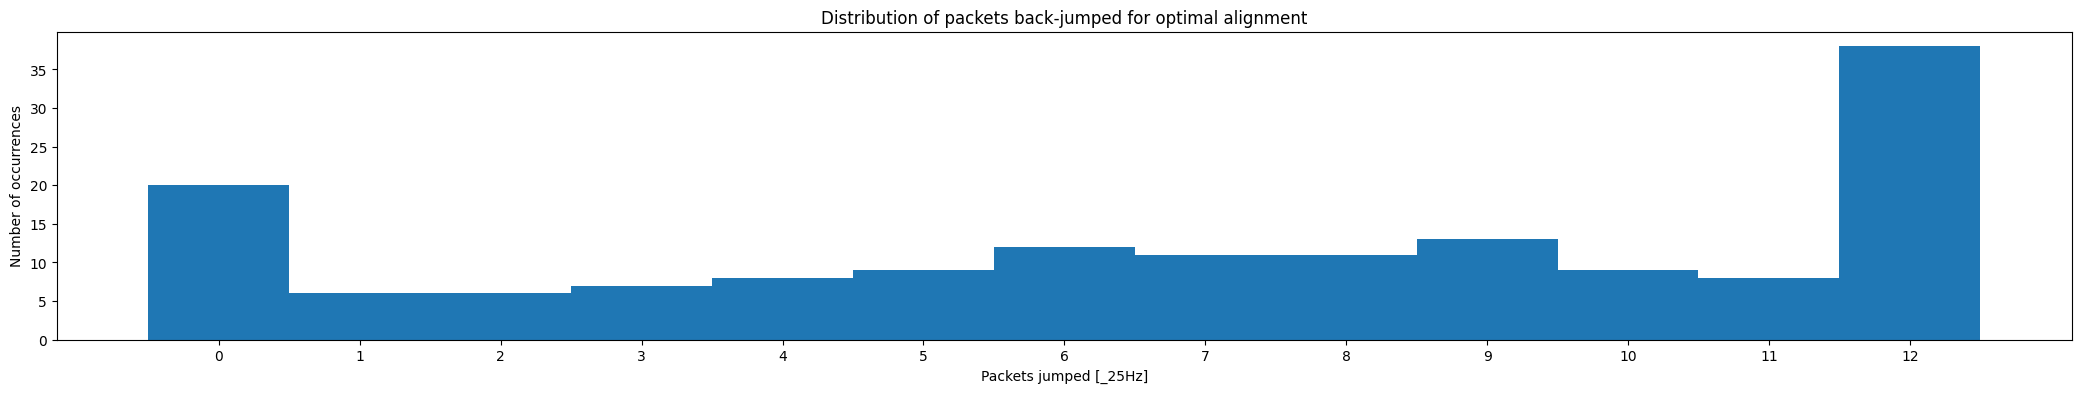

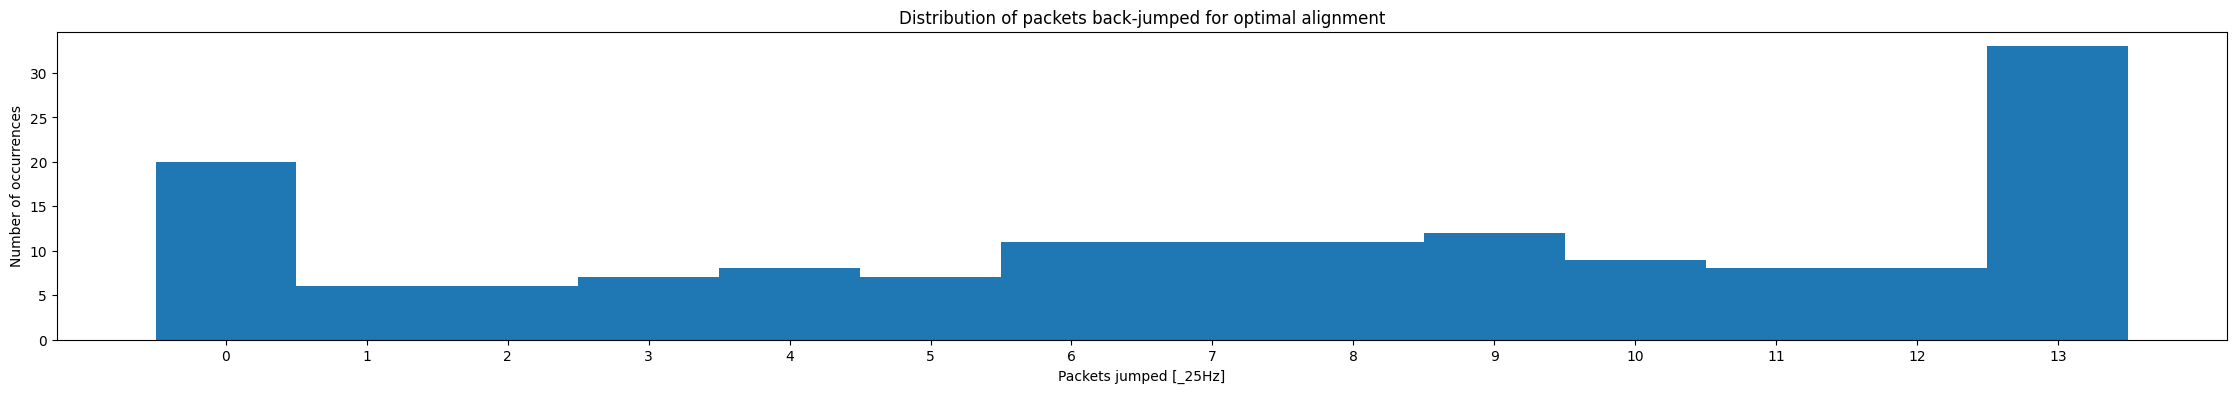

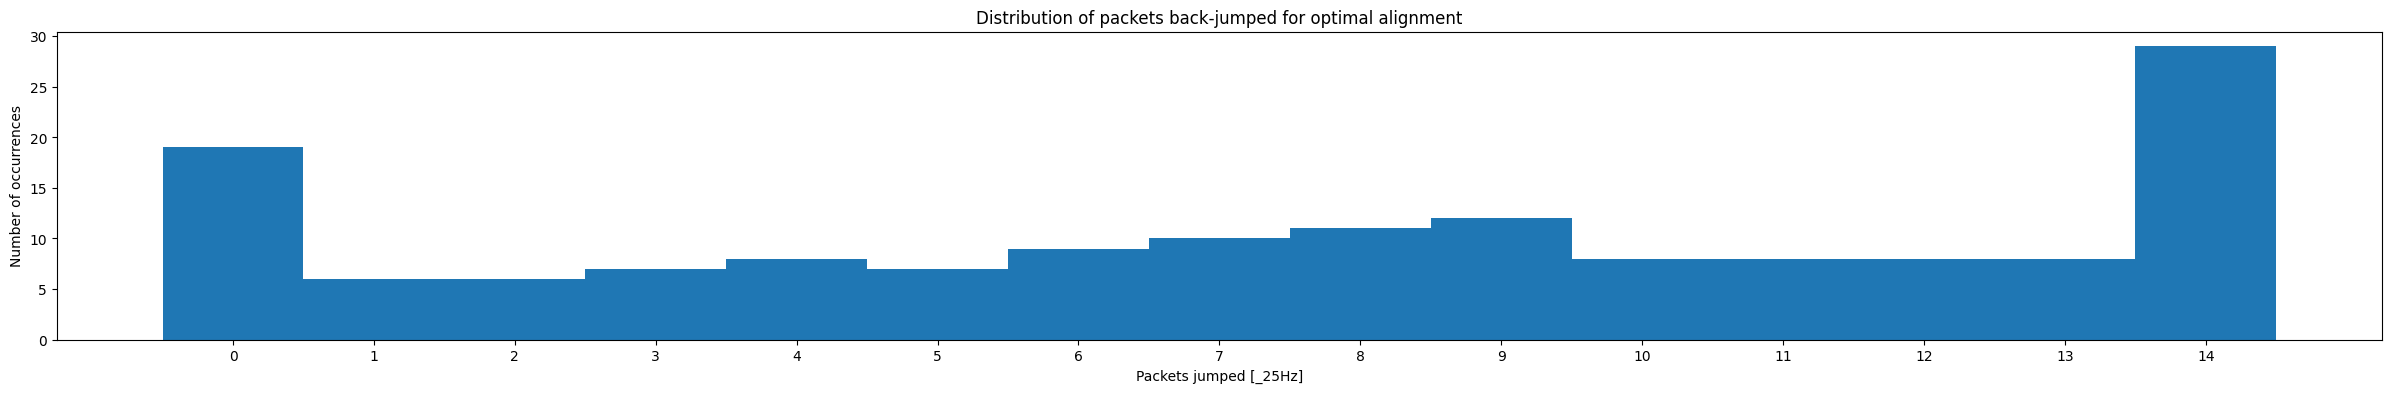

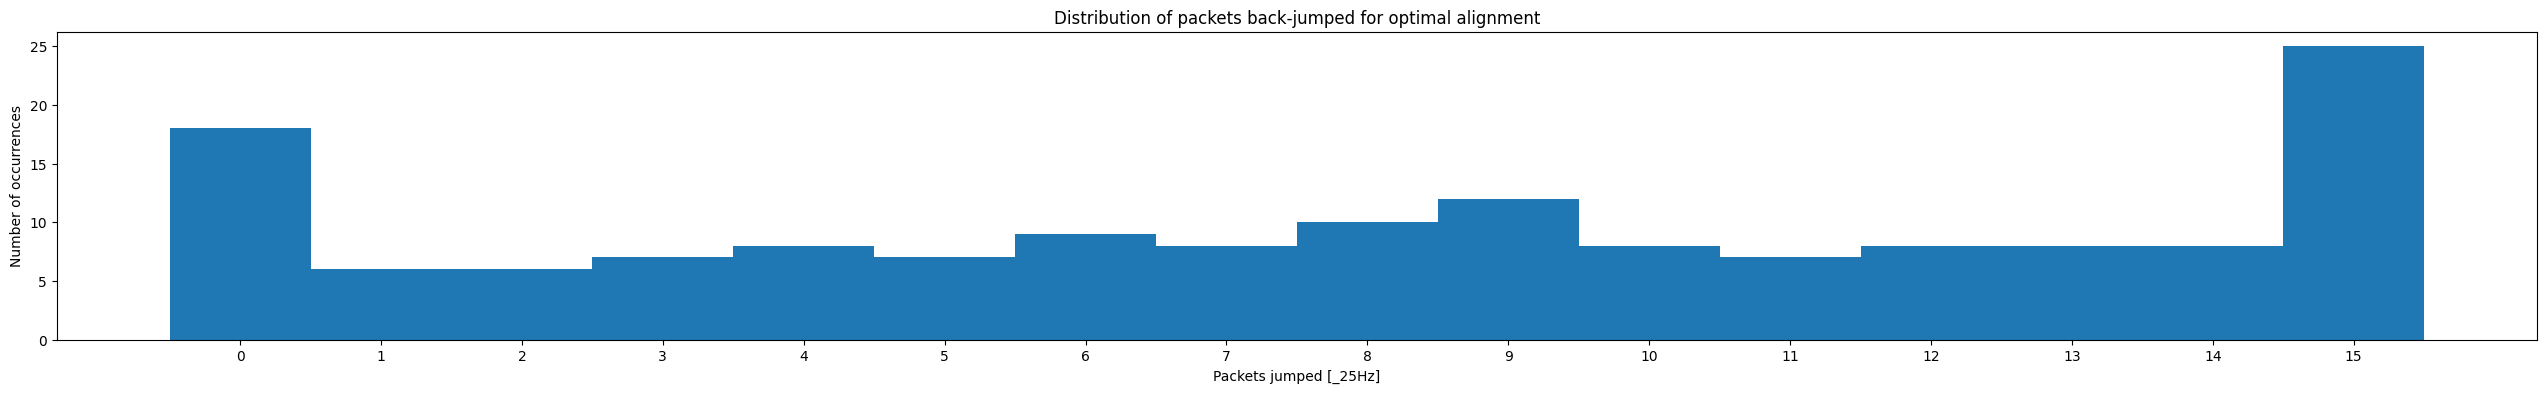

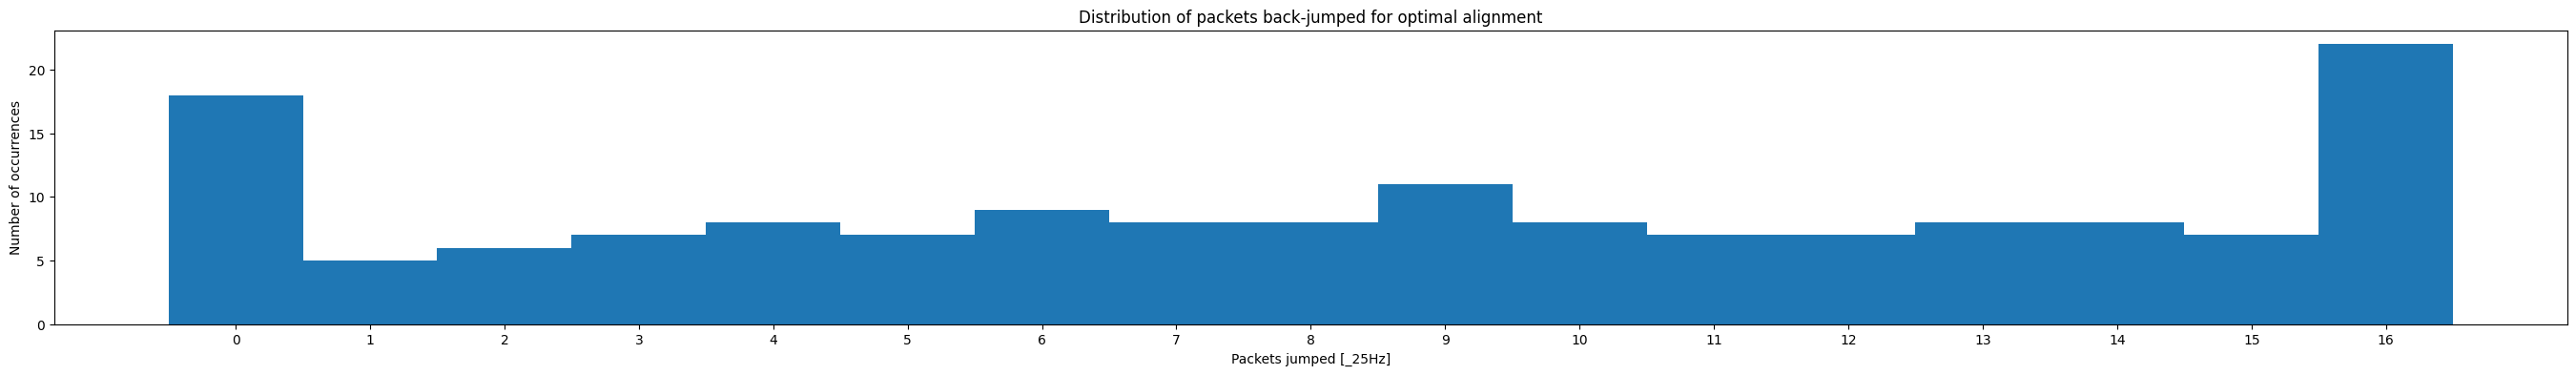

In [45]:
plot_histograms_of_the_day("files/2023_5_3", "_25Hz", [(170, 320), (320, 490)], [12,13,14,15,16,17], True)